# Modeling of Logistic Regression Classifier for Amazon Food Review

In [1]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import sqlite3 as sq
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import TimeSeriesSplit , train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from imblearn import over_sampling
from tabulate import tabulate as tab
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# Establishing a connection with amazon review database in sqlite format.
connection = sq.connect("database.sqlite")

In [3]:
# Reading the database file using pandas read sql query in AmazonReviewData variable.
AmazonReview = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""" , connection)

In [171]:
AmazonReview.shape

(525814, 10)

In [172]:
AmazonReview.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


* Replacing the score of the review with positive (score > 3) and negative (score < 3).

In [173]:
def Score(num):
    if num < 3:
        return 'negative'
    else:
        return 'positive'
    

In [174]:
score = []

for x in range (len(AmazonReview)):
    num = Score(AmazonReview['Score'][x])
    score.append(num)
AmazonReview['Score'] = score

In [175]:
AmazonReview.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Observations:

The dataset has 525814 reviews and 10 features.  
The amazon review dataset provides the following data:  
1) Id - review ID  
2) ProductID - unique Id for a given product  
3) UserID - Unique Id for the user  
4) ProfileName - Profile name of the user  
5) HelpfulnessNumerator - number of user who found the review heplful  
6) HelpfulnessDenominator - total number of users who found the review to be helpful or not.  
7) Score - product rating between 1 to 5 ( 3 been neutral, 1 & 2 been negative and 4 & 5 been positive)  
8) Time - timestamp of the review  
9) Summary - brief sumary of the review  
10) Text - text of the review  

Objective is to determine whether a given review is positive or negative using K-NN classifier.  
To do this, we replace the score column of amazon review as positive or negative by replacing all the values in score column below 3 as negative and above 3 as positive. All the reviews with score 3 are omitted, since they are neutral reviews (Neutral reviews donot help us in determining whether a given review is positive or negative).

In [176]:
# Removing all the duplicate data from the review.
AmazonReviewDataFiltered = AmazonReview.drop_duplicates(subset = {"UserId","Time","Text"}, keep = "first", inplace = False)
AmazonReviewDataFiltered.shape

(364133, 10)

# There were  161681 duplicate reviews.

In [177]:
AmazonReviewDataFiltered[AmazonReviewDataFiltered.HelpfulnessNumerator > AmazonReviewDataFiltered.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Since HelpfulnessNumerator indicates that the review was helpful for the user and HelpfulnessDenominator indicates the whether the review has helped or not the user, therefore it is clear that helpfulnessNumerator will always be less than HelpfulnessDenominator. In all the reviews where helpfulnessNumerator is greater than HelpfulnessDenominator indicates its a false entry and therefore should be neglected. There are two such reviews as shown above 

In [178]:
#Program to remove those reviews where helpfulnessNumerator is greater than helpfulnessDenominator.
AmazonReviewDataFiltered = AmazonReviewDataFiltered[AmazonReviewDataFiltered.HelpfulnessNumerator <= AmazonReviewDataFiltered.HelpfulnessDenominator]
AmazonReviewDataFiltered.shape

(364131, 10)

## Text Preprocessing

In [85]:
def HtmlTagREmover(sentence):
    """Function to remove all the HTML tags in a given sentence using Regular Expressions"""
    tagPattern = re.compile('<*.?>')
    textClean = re.sub(tagPattern,r'', sentence)
    return textClean

In [86]:
def PuncRemover(sentence):
    """Function to remove all the Punctuation marks in a given sentence using regular expressions"""
    punPattern = re.sub(r'[? | ! | \ | \' | " | # | . | , | : | ( | ) | / | ]', r'', sentence)
    return punPattern

In [87]:
stopWordRequired = {'not'}
snoBallStemmer = SnowballStemmer ('english')# initialising the snowball stemmer
stopWordsEnglish = set(stopwords.words('english', )) - stopWordRequired #set of all the stopwords in english except 'not'.

In [180]:
# Program to remove stopwords, punctuations, special characters and stemming each words. 
i = 0
positivewords = [] # list to store all the positive words in a review text.
negativewords = [] # list to store all the negative words in a review text.
filteredSentence = [] # list to store all the filtered review text.
for sentn in AmazonReviewDataFiltered['Text'].values:
    filteredSent = []
    sentn = HtmlTagREmover(sentn)
    for word in sentn.split():
        for cleanedWord in PuncRemover(word).split():
            if (cleanedWord.isalpha() & (len(cleanedWord) > 2)):
                if (cleanedWord.lower() not in stopWordsEnglish):
                    stemmerWord = snoBallStemmer.stem(cleanedWord.lower())
                    filteredSent.append(stemmerWord)
                    if (AmazonReviewDataFiltered['Score'].values)[i] == 'positive':
                        positivewords.append(stemmerWord)
                    else:
                        negativewords.append(stemmerWord)
                else:
                    continue
            else:
                continue
    i += 1
    string1 =" ".join(filteredSent)
    filteredSentence.append(string1)
            

In [210]:
AmazonReviewDataFiltered['Text'] = filteredSentence# Replacing the original text of amazon review datatset with the filtered one.
AmazonReviewData['Text'].head()

In [24]:
AmazonReviewDataFiltered['Score'].value_counts()

positive    307026
negative     57105
Name: Score, dtype: int64

# Observation:
**There are 307026 positive reviews and 57105 negative reviews out of 364131 total reviews. Hence we have 84.3 % of positive reviews and 15.7% negative reviews  **

** It also tells us that the amazon review dataset has an imbalanced dataset.**

In [25]:
#Program to form a sentence using all the positive words from the review text.
positivesent = ''
for word in positivewords:
    positivesent += ' ' + word

In [26]:
#Program to form a sentence using all the negative words from the review text.
negativesent = ''
for word in negativewords:
    negativesent += ' ' + word

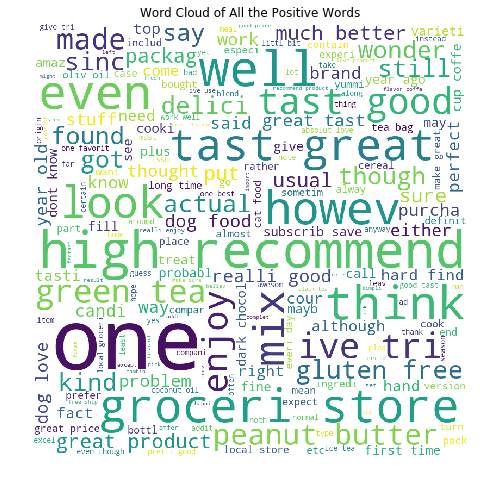

In [30]:
print('Sentence with all positive words in the reviews :\n')
print(positivesent[:25])
print('\n')
print('Sentence with all negative words in the reviews :\n')
print(negativesent[:25])

#Program to form a word cloud of all the positive in the review text.
wordcloud_positive_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(positivesent) 

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_positive_words)
plt.title("Word Cloud of All the Positive Words")
plt.axis('off')
plt.show()


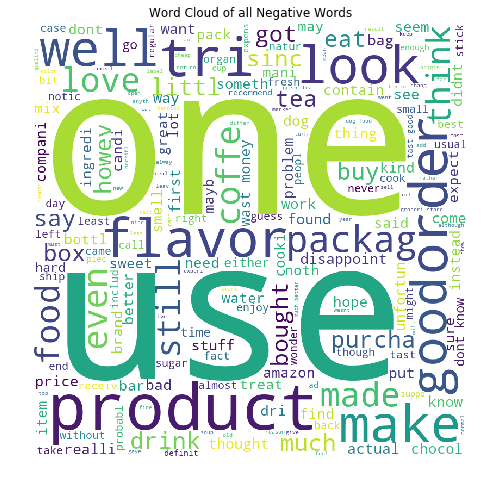

In [70]:
#Program to form a word cloud of all the positive in the review text.
wordcloud_negative_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(negativesent) 

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_negative_words)
plt.title("Word Cloud of all Negative Words")
plt.axis('off')
plt.show()

In [32]:
# Sampling 100k data points from AmazonREviewDataFiltered to perform BoW, TF - IDF, word2vec and TF - IDF avgerage w2v, to reduce processing time.
AmazonPositiveReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 'positive'].sample(n =84300) # Sampling 84300 positive data points from AmazonReviewDataFiltered, i.e. 84.3%
AmazonNegativeReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 'negative'].sample(n = 15700) # Sampling 15700 negative data points from AmazonReviewDataFiltered, i.e. 15.7%
3AmazonReviewDataSampled = AmazonPositiveReviewData.append(AmazonNegativeReviewData, ignore_index= True) # Appending the samples of positive and negative data points to form AmazonReviewDataSampled 

In [53]:
# Extablishing connection and storing the filtered amazon data set in AmazonReviewDataSampled.sqlite database
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled.to_sql('Reviews', conn,if_exists= 'replace' )

In [2]:
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled = pd.read_sql_query("""SELECT * FROM Reviews """, conn)

In [3]:
#AmazonReviewDataSampled = AmazonReviewDataSampled.drop('level_0', axis = 1)
AmazonReviewDataSampled.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,positive,1234137600,Excellent taste and quality,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,positive,1285718400,Limited Variety,candi good childhood favorit mani get bag piec...
2,2,323478,B000LNWIVU,A12Y0FZ2EZUU2K,"Jill E. Trainor ""Jillylam""",6,7,positive,1179100800,Victor Fly Bag is Great!,purchas item put near chicken coop first thoug...
3,3,436119,B001I8DP5U,A2LXIOHTEYTFUW,"Hyena ""The world is upheld by the veracity of...",0,0,positive,1310169600,GOOD COFFEE,excel cup favorit regular folger not like cost...
4,4,259662,B0032AM8HS,A13NB7KO0EQ24J,"J. Rosenberg ""Jenrose""",1,1,positive,1308528000,One of the best tools in my tool chest for dea...,tea tasti import knock back queasi start first...


** Replacing Positive and Negative Scores with Binary 1 and 0. **

In [4]:
def binaryScore(num):
    if num != 'positive':
        return 0
    else:
        return 1

In [5]:
binary = []

for x in range (len(AmazonReviewDataSampled)):
    num = binaryScore(AmazonReviewDataSampled['Score'][x])
    binary.append(num)
AmazonReviewDataSampled['Score'] = binary
    

In [6]:
AmazonReviewDataSampled.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,1,1234137600,Excellent taste and quality,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,1,1285718400,Limited Variety,candi good childhood favorit mani get bag piec...
2,2,323478,B000LNWIVU,A12Y0FZ2EZUU2K,"Jill E. Trainor ""Jillylam""",6,7,1,1179100800,Victor Fly Bag is Great!,purchas item put near chicken coop first thoug...
3,3,436119,B001I8DP5U,A2LXIOHTEYTFUW,"Hyena ""The world is upheld by the veracity of...",0,0,1,1310169600,GOOD COFFEE,excel cup favorit regular folger not like cost...
4,4,259662,B0032AM8HS,A13NB7KO0EQ24J,"J. Rosenberg ""Jenrose""",1,1,1,1308528000,One of the best tools in my tool chest for dea...,tea tasti import knock back queasi start first...


In [7]:
# Program to split the positive and negative reviews of the amazon dataset based on time.
AmazonReviewDataSampledPositive = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 1]

AmazonReviewDataSampledNegative = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 0]
# Program to sort the positive and negative review dataset with respect to time.
AmazonReviewDataSampledPositive.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True )
AmazonReviewDataSampledNegative.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True)

In [8]:
AmazonReviewDataSampledPositive.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44503,44503,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...
76271,76271,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,one movi movi collect fill comedi action whate...
14486,14486,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,get crazyim look beatlejuic french version vid...
49280,49280,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,realli good idea final product outstand use de...


In [9]:
AmazonReviewDataSampledNegative.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
89700,89700,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,992217600,CASPER IS THE GHOST WITH THE MOST,michael keaton bring distinguish characterist ...
93897,93897,230327,B00004RYGX,A3M5O6UHXO9IBU,Gary,2,34,0,1052265600,Certificate: Puerile,embarrass comedi come like child attent defici...
94769,94769,225941,B000PKFZH8,A375QRG43POEW6,dndnd,23,25,0,1069977600,Stay Away...,product ship great packag look good tast horri...
93593,93593,342462,B000084F3O,A3DWUM6SN3N3NR,"Author Brian Wallace (Mind Transmission, Inc.)",4,33,0,1076457600,the most unnatural odor,realli hate fan van patten year feel must save...


In [10]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset.
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

In [11]:
AmazonReviewDataSampledTrain.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44503,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...
1,76271,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,one movi movi collect fill comedi action whate...
2,14486,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,get crazyim look beatlejuic french version vid...
3,49280,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,realli good idea final product outstand use de...
4,64330,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,sick scad nasti toothpick counter tint concept...


In [12]:
AmazonReviewDataSampledTest.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,37662,192950,B000OV08FC,A3DMVZ9D6XSS1E,Hannah,0,0,1,1328572800,Good coffee,easi quick make heat water empti sachet lot le...
1,84246,107310,B005DFL4PM,AOTUPV596EAHL,Callie14,0,0,1,1328572800,OMG... like Reeses,bought most put protein shake without calori l...
2,23050,420167,B005NVU5BK,A2J19U8H5SSFCJ,Linda Dalton,0,0,1,1328572800,Excellent chocolate,never heard brand amazon offer special promot ...
3,27788,120546,B005K4Q37A,AYWXEYT90R54K,Jennifer Komarek,0,0,1,1328572800,Love it!,not big coffe drinker drink coffe use lot crea...
4,38612,56323,B0039ZOZ86,A24EDLRX54TE36,"Gretchen Fehling ""tawonda""",1,1,1,1328572800,great snack for dieters!@,great dieter calori per pack great throw lucnc...


In [13]:
AmazonReviewDataSampledTrain['Score'].value_counts()

1    59010
0    10990
Name: Score, dtype: int64

# Observation: The train dataset has 59k positive reviews and 10k negative reviews. Hence the train dataset is imbalanced. The total reviews in the train dataset is 70k.

In [14]:
AmazonReviewDataSampledTest['Score'].value_counts()

1    25290
0     4710
Name: Score, dtype: int64

# Observation: The test dataset has 25k positive reviews and 4.7k negative reviews. Total reviews in test dataset is 30k

# Vectorizing the Text column of the Dataset

# 1) Bag of Words Vectorizer

In [18]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

<70000x42841 sparse matrix of type '<class 'numpy.int64'>'
	with 2195461 stored elements in Compressed Sparse Row format>

# Observation : BOW for training dataset is a sparse matrix with 42.8k dimensions.

In [19]:
# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest

<30000x42841 sparse matrix of type '<class 'numpy.int64'>'
	with 935696 stored elements in Compressed Sparse Row format>

# Observation : BOW for test dataset is a sparse matrix with 42.8k dimensions.

#  2) TF - IDF Vectorizer

In [20]:
#Inilialzing and obtaining the TF-IDF of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

In [21]:
features = tfidfVec.get_feature_names()# to get the features of tfidf vector.
tfidfVecTrain

<70000x994451 sparse matrix of type '<class 'numpy.float64'>'
	with 4738319 stored elements in Compressed Sparse Row format>

# Observation : TFIDF for train and test dataset is a sparse matrix with 99.4k dimensions.

In [22]:
#obtaining the TF-IDF of the Test Dataset.
tfidfVecTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])
tfidfVecTest

<30000x994451 sparse matrix of type '<class 'numpy.float64'>'
	with 1732295 stored elements in Compressed Sparse Row format>

# 3) W2V and TFIDFW2V Vectorizer

In [16]:
#Program to obtain list of sentences from the train dataset.
i = 0 
listofsent = []
for sent in AmazonReviewDataSampledTrain['Text']:
    listofsent.append(sent.split())

In [17]:
# Training W2V model using the training dataset.
w2v_model = Word2Vec(listofsent, size = 50, min_count = 5, workers = 4)

In [18]:
w2vecmodel = open('w2vmodel', 'wb')
pickle.dump(w2v_model, w2vecmodel)

In [243]:
#Program to obtain the w2v, avgw2v and tfidf-w2v for the training dataset.
word2vectorsTrain = []  # list to store the word2vec for training dataset
avgWord2VectorTrain = []  # list to store avg word2vec for training dataset
tfidfweightedAvgWord2VecTrain = []  # list to store tfidf avg word2vec for training dataset
row = 0
for sentence in AmazonReviewDataSampledTrain['Text'].values:  # obtaining the text of each review.
    #print(row)
    sentenceVector= np.zeros(50)  # initializing a vector of dimension 50 to store the word2vec for each word of a text of given review.
    tfword2Vec = np.zeros(50)  # initializing a vector of dimension 50 to store the tfidf of each word in a text of a given review
    count = 0
    weight = 0
    for word in sentence.split():  # obtain each word of a given text and obtianing the vector of each word.
        #print(word)
        if word in (w2v_model.wv.vocab):
            sentenceVector += w2v_model.wv[word] # obtaining the word2vec for each sentenc in a given review text.
            wordvec = w2v_model.wv[word]  # obtaining the word2vec for each word.
            tfidf1 = tfidfVecTrain[row, features.index(word)]  # obtaining the TFIDF vector of word.
            tfword2Vec += (wordvec * tfidf1)  # obtaining the tfidf for each sentence in a given review text.
            count += 1

            weight += tfidf1
        else:
            continue
    word2vectorsTrain.append(sentenceVector)  # word2vec for each review text.
    if count != 0:
        sentenceVector /= count
    avgWord2VectorTrain.append(sentenceVector)  # avg word2vec for each review text.
    if weight != 0:
        tfword2Vec /= weight
    tfidfweightedAvgWord2VecTrain.append(tfword2Vec)  # tfidf avg word2vec for each review text.
    row += 1

w2vTrain = open('word2vectorsTrain', 'wb')
pickle.dump(word2vectorsTrain, w2vTrain)

avw2vTrain = open('avgWord2VectorTrain','wb')
pickle.dump(avgWord2VectorTrain, avw2vTrain)

tfidfw2vTrain = open('tfidfweightedAvgWord2VecTrain', 'wb')
pickle.dump(tfidfweightedAvgWord2VecTrain, tfidfw2vTrain)


In [244]:
 #Program to obtain the w2v, avgw2v and tfidf-w2v for the training dataset.   
word2vectorsTest = []  # list to store the word2vec for test dataset
avgWord2VectorTest = []  # list to store avg word2vec for test dataset
tfidfweightedAvgWord2VecTest = []  # list to store tfidf avg word2vec for test dataset
row = 0
for sentence in AmazonReviewDataSampledTest['Text'].values:  # obtaining the text of each review.
    
    sentenceVector= np.zeros(50)  # initializing a vector of dimension 300 to store the word2vec for each word of a text of given review.
    tfword2Vec = np.zeros(50)  # initializing a vector of dimension 300 to store the tfidf of each word in a text of a given review
    count = 0
    weight = 0
    for word in sentence.split():  # obtain each word of a given text and obtianing the vector of each word.
        # print(word)
        if word in (w2v_model.wv.vocab):
            sentenceVector += w2v_model.wv[word] # obtaining the word2vec for each sentenc in a given review text.
            wordvec = w2v_model.wv[word]  # obtaining the word2vec for each word.
            tfidf1 = tfidfVecTest[row, features.index(word)]  # obtaining the TFIDF vector of word.
            tfword2Vec += (wordvec * tfidf1)  # obtaining the tfidf for each sentence in a given review text.
            count += 1

            weight += tfidf1
        else:
            continue
    word2vectorsTest.append(sentenceVector)  # word2vec for each review text.
    if count != 0:
        sentenceVector /= count
    avgWord2VectorTest.append(sentenceVector)  # avg word2vec for each review text.
    if weight != 0:
        tfword2Vec /= weight
    tfidfweightedAvgWord2VecTest.append(tfword2Vec)  # tfidf avg word2vec for each review text.
    row += 1

w2vTest = open('word2vectorsTest', 'wb')
pickle.dump(word2vectorsTest, w2vTest)

avw2vTest = open('avgWord2VectorTest','wb')
pickle.dump(avgWord2VectorTest, avw2vTest)

tfidfw2vTest = open('tfidfweightedAvgWord2VecTest', 'wb')
pickle.dump(tfidfweightedAvgWord2VecTest, tfidfw2vTest)
    

# Logistic Regression Classifier for the Amazon Food Review Dataset.

** We observe that the Amazon food review datatset is an imbalance dataset, with positive reviews making around 85% of the total reviews.**  

** We have the train dataset which has 59010 positive and 10990 negative reviews, while the test dataset has 25290 positive reviews and 4710 negative review. ** 

** We will model the Logistic classifier with 10 fold cross validation to find the optimal value of C (inverse of lambda ) which is the hyperparameter of the naive bayes classifier .  **  

** Since the dataset is imbalanced, AUC is used to evaluate the performance of the model. A perfect classifier would have a AUC more than 0.5 with 1 been the best and 0 been the worse. **

** We will determine the hyperparameter C of the Logistic Regression using two methods : **  
** 1) GridsSearch. **  
** 2) Random Search.**  

** Since Bag of Words and TFIDF are sparse matrices, we will standardize, these vectors using Max absolute scaler, which is best suited for standardizing sparse matrices. W2v and TFIDFW2V will be standardize using standardScaler method. **

# Obejective :  To determine whether a given Review is a positive review or not.

In [15]:
def clf(x_train,y_train,typeSearch,regularizer):
    """Function to determine the optimal value of hyperparameter c (= 1 / lambda) using gridsearch and random search technique. Note: Regularizer is either l1 or l2. """
    classifier = LogisticRegression(penalty= regularizer,class_weight={1 : 1, 0: 5})# since dataset is imbalanced, class weight is set to 1:5 for resampling the minority class
    if typeSearch == 'GridSearch':
        tuned_parameters = [{'C': [10**-4, 10**-2,10**-1, 10**0,10**1, 10**2, 10**4]}] # C values
        model = GridSearchCV(classifier, tuned_parameters, scoring = 'roc_auc', cv=10, n_jobs = -1) # initializing grid search for logistic regression
        model.fit(x_train,y_train)
        
        
    else:
        tuned_param = {'C': [10**-10, 10**-9, 10**-8, 10**-7, 10**-6,10**-5, 10**-4, 10**-3, 10**-2, 10**-1,10**0, 10**1, 10**2, 10**3, 10**4,10**5, 10**6, 10**7, 10**8, 10**9,10**10]}
        model = RandomizedSearchCV(classifier,tuned_param,scoring = 'roc_auc', cv = 10,n_jobs = -1,n_iter=5) # initializing random search for logistic regression
        model.fit(x_train,y_train)
    
    return model.cv_results_,model.best_params_     
    

In [16]:
def clfPerformance(x_train,y_train,x_test,y_test,optimal_param,regularizer):
    """Function to determine the performance of Logistic Regression."""
    model_performance = LogisticRegression(penalty= regularizer,class_weight={1 : 1, 0: 5}, C = optimal_param, n_jobs = -1)
    model_performance.fit(x_train,y_train)
    predicted = model_performance.predict(x_test)
    auc = roc_auc_score(y_test,predicted) # calculating the AUC
    confusionMatrix = confusion_matrix(y_test,predicted) # obtaining the confusion matrix
    TPR = (confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])) * 100 # calculating the TPR 
    TNR = (confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])) * 100 # calculating the TNR
    print('Optimal C \tAUC \t\tTPR \t\tTNR')
    print('%r \t\t%.3f \t\t%.3f \t\t%.3f'%(optimal_param,auc,TPR,TNR))
    
    return model_performance.coef_ ,model_performance.classes_

In [17]:
def PertubationTest(x_train,y_train,weights,regularizer,optimal_param,vectorizer):
    """Function to check whether the features are multicolinear or not"""
    clf = LogisticRegression(penalty = regularizer, class_weight ={1 : 1, 0: 5}, C = optimal_param,n_jobs = -1 )
    clf.fit(x_train,y_train)
    weightsPert = clf.coef_[0] # weights after pertubation
    weightsPert += 10 ** (-6) # adding a small value to weights to avoid divide by zero.
    perChange = abs((weights - weightsPert) / weights) * 100 # calculating the percentage change of weights before pertubation and after pertubation
    return perChange



In [18]:
def TopFeatures(numoffeat, vectorizer, coef):
    """Function to print top features in positive and negative class"""
    feature_names = vectorizer.get_feature_names()# obtaining the feature names for a particular vectorizer.
    coefs_with_fns = sorted(zip(coef, feature_names))# assigning each weights with its corresponding feature names
    top = zip(coefs_with_fns[:numoffeat], coefs_with_fns[:-(numoffeat + 1):-1])
    print("%r Most important features in Positive and Negative Class" % (numoffeat))
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("---------------------------------------------------------------------------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# Program to Train and Test the Logistic Regression Classifier using Bag Of Words Vectorizer

** Logistic Regression using GridSearch and L2 penalty **

In [19]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [22]:
aucScore, optimalParam = clf(bowTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([ 0.33585722,  0.62641337,  1.07318764,  2.34632199,  4.87698741,
         9.78362627, 22.70871928]),
 'std_fit_time': array([0.0104807 , 0.01906639, 0.02884885, 0.33538694, 0.14331394,
        0.91042226, 6.9675905 ]),
 'mean_score_time': array([0.00312736, 0.00156612, 0.00625176, 0.0046859 , 0.00624454,
        0.00156219, 0.00469646]),
 'std_score_time': array([0.00625473, 0.00469837, 0.00765683, 0.00715783, 0.00764797,
        0.00468657, 0.00717397]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.90009728, 0.92207456, 0.93145623, 0.92870257, 0.91176046,
        0.88478873, 0.85802039]),
 'split1_test_score': array([0.89602786, 0.91853943, 0.92796628, 0.92453524, 0.90682753,

In [23]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [20]:
coef, classlabel = clfPerformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.879 		90.059 		85.817


# To Test whether the features are Multicollinear using Pertubation Test

In [21]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

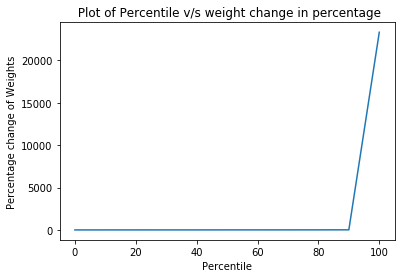

In [23]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChane,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

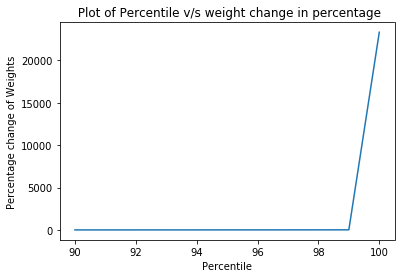

 Percentile : [1.61173579e-04 4.65839584e-01 9.45502918e-01 1.46073914e+00
 2.07837735e+00 2.82050559e+00 3.83845735e+00 5.28386133e+00
 7.33450362e+00 1.10969248e+01 2.33277967e+04]


In [25]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChane,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [26]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChane,percentList2)
percentile

array([   56.9674063 ,    64.46095143,    75.94935777,    92.87347846,
         104.93489282,   134.9801708 ,   178.33443684,   314.39330468,
         596.41437039, 23327.79670782])

# Observation: From above two graphs we see that, above 99.9 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [29]:
numOfFeatures = percentageChane[np.where(percentageChane > np.percentile(percentageChane,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.9 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChane, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.9 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.9 percentile is : 43
Top 10 features having weights change more than 99.9 percentile
(23327.796707817004, 'forklift')
(22021.135805165417, 'wade')
(17829.127583125548, 'mudslid')
(16200.844826188666, 'envirobox')
(9309.910133775484, 'silkiest')
(6400.656673443718, 'richest')
(3105.539305198017, 'akc')
(2674.4290346891025, 'peoni')
(2140.0453625827495, 'outbut')
(1978.830717483319, 'tomato')


In [30]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

1.001 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [202]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-6.5650	not            				6.8538	great          
	-4.8051	disappoint     				6.0560	love           
	-3.9055	worst          				5.0075	delici         
	-3.4757	horribl        				4.9501	best           
	-3.3320	terribl        				4.0416	excel          
	-3.3240	aw             				3.9853	perfect        
	-3.2563	tast           				3.6410	good           
	-3.0828	return         				3.4585	nice           
	-2.9066	stale          				3.0858	favorit        
	-2.8410	bad            				2.7402	easi           
	-2.7672	didnt          				2.6425	wonder         
	-2.7057	threw          				2.5728	keep           
	-2.5597	money          				2.5335	happi          
	-2.4913	bland          				2.4334	awesom         
	-2.4189	unfortun       				2.4314	tasti          
	-2.3313	thought        				2.4201	thank          
	-2.31

** Logistic Regression using GridSearch and L1 penalty **

In [30]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [20]:
aucScore, optimalParam = clf(bowTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([7.20385289e-01, 3.41314883e+00, 4.34254487e+00, 1.44713151e+01,
        3.14169708e+01, 1.03852570e+02, 1.09500007e+04]),
 'std_fit_time': array([8.11636649e-02, 1.46563824e-01, 3.16397940e-01, 1.97926940e+00,
        9.01658649e+00, 6.67174375e+01, 4.13426538e+02]),
 'mean_score_time': array([0.01887765, 0.01772044, 0.015692  , 0.01874554, 0.01718557,
        0.01718137, 0.02031066]),
 'std_score_time': array([0.00618981, 0.00596462, 0.00249424, 0.00624365, 0.00468521,
        0.00468915, 0.0071564 ]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.5       , 0.85911419, 0.92138298, 0.92377767, 0.8898629 ,
        0.83812972, 0.82118421]),
 'split1_test_score': array([0.5       

In [21]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [31]:
coef, classlabel = clfPerformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.873 		87.991 		86.603


# To Test whether the features are Multicollinear using Pertubation Test

In [32]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

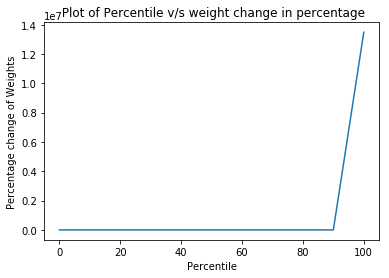

In [33]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

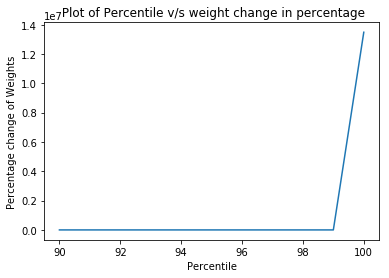

 Percentile : [       0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.         13485508.40609425]


In [34]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [35]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([2.57226657e+00, 2.95554009e+00, 3.35527686e+00, 4.08053873e+00,
       4.75763102e+00, 6.03091460e+00, 8.52164706e+00, 1.46567191e+01,
       4.05483216e+01, 1.34855084e+07])

# Observation: From above two graphs we see that, above 99.8 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [36]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.8))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.8 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.8 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.8 percentile is : 86
Top 10 features having weights change more than 99.8 percentile
(13485508.406094255, 'complet')
(11689869.302165221, 'graini')
(8486686.020145558, 'eye')
(6830459.915073071, 'inform')
(3995657.123285532, 'tart')
(3747875.825381802, 'stupid')
(2423967.743290443, 'wierd')
(1462567.1567629697, 'new')
(1436315.9884180748, 'tri')
(626144.3701520737, 'challeng')


In [37]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.201 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [25]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-8.9688	not            				9.3274	love           
	-8.1425	worst          				9.1605	great          
	-6.1210	horribl        				8.4072	delici         
	-5.9072	disappoint     				7.6404	excel          
	-5.7795	return         				6.5777	best           
	-5.3399	terribl        				6.4307	perfect        
	-5.2401	tast           				5.2233	good           
	-5.0528	aw             				5.0624	nice           
	-4.9927	refund         				4.6984	keep           
	-4.6950	disgust        				4.5563	amaz           
	-4.6055	gross          				4.1167	yummi          
	-4.5150	stale          				4.0994	refresh        
	-4.3877	weak           				4.0143	happi          
	-4.3523	china          				3.9306	without        
	-4.3481	stick          				3.9159	favorit        
	-4.2680	ruin           				3.8520	year           
	-4.09

** Logistic Regression using Random Search and L2 penalty **


In [38]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [27]:
aucScore, optimalParam = clf(bowTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([  2.56658905,   4.5926686 ,   1.68710155, 101.7275902 ,
         79.06574404]),
 'std_fit_time': array([ 0.03426092,  0.13528685,  0.10956918, 25.54050043, 10.62608883]),
 'mean_score_time': array([0.01249654, 0.01250052, 0.00624871, 0.00781362, 0.00468664]),
 'std_score_time': array([0.00624827, 0.00625026, 0.00765308, 0.00781362, 0.00715896]),
 'param_C': masked_array(data=[0.01, 0.1, 0.001, 10000, 10000000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01},
  {'C': 0.1},
  {'C': 0.001},
  {'C': 10000},
  {'C': 10000000000}],
 'split0_test_score': array([0.92207456, 0.93145623, 0.90865415, 0.85802039, 0.85790212]),
 'split1_test_score': array([0.91853943, 0.92796628, 0.90452953, 0.83105052, 0.83402499]),
 'split2_test_score': array([0.92973014, 0.93982374, 0.91238434, 0.82703507, 0.85460585]),
 'split3_test_score': array([0.9324599 , 0.94143881, 0.91802241, 0.8484139 , 0.817

In [28]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [39]:
coef, classlabel = clfPerformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.879 		90.059 		85.817


# To Test whether the features are Multicollinear using Pertubation Test

In [40]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

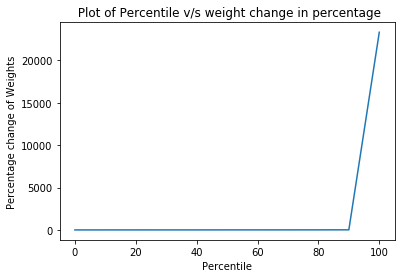

In [41]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

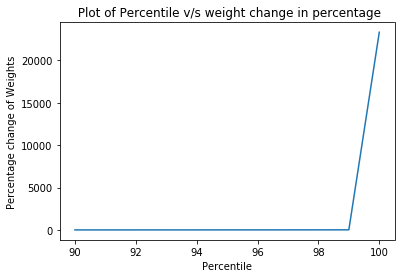

 Percentile : [1.61173579e-04 4.65839584e-01 9.45502918e-01 1.46073914e+00
 2.07837735e+00 2.82050559e+00 3.83845735e+00 5.28386133e+00
 7.33450362e+00 1.10969248e+01 2.33277967e+04]


In [42]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [43]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([   56.9674063 ,    64.46095143,    75.94935777,    92.87347846,
         104.93489282,   134.9801708 ,   178.33443684,   314.39330468,
         596.41437039, 23327.79670782])

# Observation: From above two graphs we see that, above 99 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [198]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.1))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99 percentile is : 386
Top 10 features having weights change more than 99 percentile
(23327.796707817004, 'forklift')
(22021.135805165417, 'wade')
(17829.127583125548, 'mudslid')
(16200.844826188666, 'envirobox')
(9309.910133775484, 'silkiest')
(6400.656673443718, 'richest')
(3105.539305198017, 'akc')
(2674.4290346891025, 'peoni')
(2140.0453625827495, 'outbut')
(1978.830717483319, 'tomato')


In [199]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.901 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [31]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-6.5650	not            				6.8538	great          
	-4.8051	disappoint     				6.0560	love           
	-3.9055	worst          				5.0075	delici         
	-3.4757	horribl        				4.9501	best           
	-3.3320	terribl        				4.0416	excel          
	-3.3240	aw             				3.9853	perfect        
	-3.2563	tast           				3.6410	good           
	-3.0828	return         				3.4585	nice           
	-2.9066	stale          				3.0858	favorit        
	-2.8410	bad            				2.7402	easi           
	-2.7672	didnt          				2.6425	wonder         
	-2.7057	threw          				2.5728	keep           
	-2.5597	money          				2.5335	happi          
	-2.4913	bland          				2.4334	awesom         
	-2.4189	unfortun       				2.4314	tasti          
	-2.3313	thought        				2.4201	thank          
	-2.31

** Logistic Regression using Random Search and L1 penalty **

In [44]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [31]:
aucScore, optimalParam = clf(bowTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([4.19428031e+00, 9.22991657e-01, 1.95385625e+04, 1.87898262e+04,
        2.07149339e+00]),
 'std_fit_time': array([4.52499840e-01, 1.19854997e-01, 8.96683931e+02, 4.89688436e+02,
        2.33418955e-02]),
 'mean_score_time': array([0.018747  , 0.0157114 , 0.03280416, 0.01665726, 0.01562438]),
 'std_score_time': array([6.24864430e-03, 1.08981322e-03, 1.47353902e-02, 9.73993032e-03,
        3.68154109e-06]),
 'param_C': masked_array(data=[0.1, 0.0001, 100000000, 1000000000, 0.001],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1},
  {'C': 0.0001},
  {'C': 100000000},
  {'C': 1000000000},
  {'C': 0.001}],
 'split0_test_score': array([0.9213782, 0.5      , 0.8111529, 0.7901921, 0.5      ]),
 'split1_test_score': array([0.92160996, 0.5       , 0.77507444, 0.7829163 , 0.5       ]),
 'split2_test_score': array([0.92945429, 0.5       , 0.78703506, 0.79854219, 0.5       ]),
 'split3_test_sc

In [32]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [45]:
coef, classlabel = clfPerformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.873 		87.991 		86.603


# To Test whether the features are Multicollinear using Pertubation Test

In [47]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

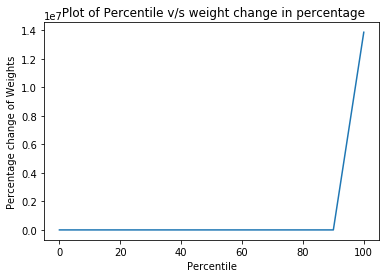

In [48]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

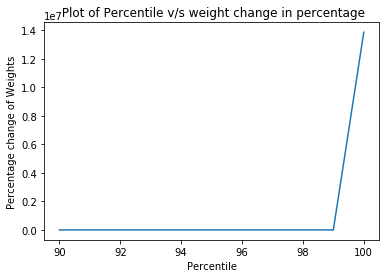

 Percentile : [1.34591140e-02 5.00000000e+01 5.00000000e+01 5.00000000e+01
 5.00000000e+01 5.00000000e+01 5.00000000e+01 5.00000000e+01
 5.00000000e+01 5.00000000e+01 1.38735164e+07]


In [49]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [50]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([5.00000000e+01, 5.00000000e+01, 5.00000000e+01, 5.00000000e+01,
       5.00000000e+01, 5.00000000e+01, 5.00000000e+01, 5.00000000e+01,
       1.57708759e+02, 1.38735164e+07])

# Observation: From above two graphs we see that, above 99.8 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [51]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.8 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.8 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.8 percentile is : 43
Top 10 features having weights change more than 99.8 percentile
(13873516.39383873, 'eye')
(12591643.571182504, 'complet')
(12267165.602752829, 'graini')
(7357104.981470374, 'inform')
(4612373.421442106, 'stupid')
(3923008.6305879303, 'tart')
(3781333.8500078456, 'oil')
(3573789.8404104416, 'ship')
(3107143.9053956545, 'wierd')
(2653951.3586996165, 'total')


In [52]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.100 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [36]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-8.9685	not            				9.3278	love           
	-8.1423	worst          				9.1609	great          
	-6.1210	horribl        				8.4074	delici         
	-5.9071	disappoint     				7.6407	excel          
	-5.7793	return         				6.5779	best           
	-5.3399	terribl        				6.4309	perfect        
	-5.2401	tast           				5.2237	good           
	-5.0528	aw             				5.0626	nice           
	-4.9926	refund         				4.6985	keep           
	-4.6950	disgust        				4.5564	amaz           
	-4.6054	gross          				4.1172	yummi          
	-4.5150	stale          				4.0995	refresh        
	-4.3876	weak           				4.0144	happi          
	-4.3522	china          				3.9307	without        
	-4.3480	stick          				3.9161	favorit        
	-4.2680	ruin           				3.8520	year           
	-4.09

# Program to Train and Test the Logistic Regression Classifier using TFIDF Vectorizer

** Logistic Regression using GridSearch and L2 penalty **

In [53]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain = maxscaler.fit_transform(tfidfVecTrain)
tfidfVecTest = maxscaler.transform(tfidfVecTest)

In [38]:
aucScore, optimalParam = clf(tfidfVecTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([ 10.58814111,  24.0450949 ,  39.68822098,  75.06739168,
        102.23356543, 128.46664317,  99.81963835]),
 'std_fit_time': array([ 0.1633612 ,  0.45677647,  0.50062388,  5.94387846,  4.16720308,
         5.19745044, 23.45927962]),
 'mean_score_time': array([0.0343684 , 0.04061999, 0.04530442, 0.0421762 , 0.04686861,
        0.04530239, 0.01874962]),
 'std_score_time': array([0.0062517 , 0.00765194, 0.00840907, 0.00999836, 0.00988272,
        0.00841067, 0.0093766 ]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.91053428, 0.93612717, 0.9469199 , 0.94943193, 0.9496842 ,
        0.94966831, 0.94912569]),
 'split1_test_score': array([0.90192128, 0.9357002 , 0.95083497, 0.9545370

In [40]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10


In [54]:
coef, classlabel = clfPerformance(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],tfidfVecTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
10 		0.862 		96.647 		75.817


# To Test whether the features are Multicollinear using Pertubation Test

In [55]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

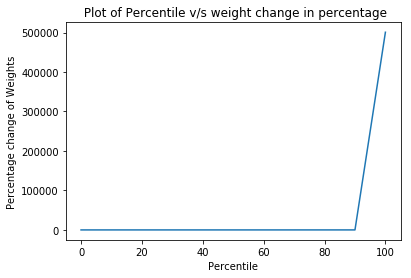

In [56]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

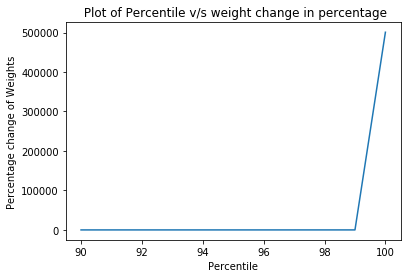

 Percentile : [3.44065405e-07 5.35369960e-01 1.07182685e+00 1.69496550e+00
 2.49966146e+00 3.60474508e+00 5.12972089e+00 7.42377052e+00
 1.10242536e+01 1.73307285e+01 5.00688619e+05]


In [57]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [58]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([5.29596919e+01, 5.83575102e+01, 6.85399206e+01, 7.61281146e+01,
       8.96924838e+01, 1.05620210e+02, 1.58150308e+02, 2.45709312e+02,
       4.60251440e+02, 5.00688619e+05])

# Observation: From above two graphs we see that, above 99.8 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [59]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.8 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.8 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.8 percentile is : 962
Top 10 features having weights change more than 99.8 percentile
(5030.273178450925, 'vietnam')
(2883.6833270161424, 'nothi')
(2554.766802172062, 'reagan')
(2554.766802172062, 'hamberg')
(2408.7808594374383, 'bless')
(2314.287070953467, 'jetson')
(2314.287070953467, 'halfdom')
(2314.287070953467, 'calculus')
(1894.377048559317, 'addblend')
(1458.841445685928, 'pask')


In [60]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.097 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [43]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-8.1386	disappoint     				10.2929	great          
	-7.4948	worst          				9.8362	love           
	-6.5118	not good       				8.6296	delici         
	-6.3862	terribl        				8.0137	good           
	-6.3667	horribl        				7.9220	best           
	-6.3154	not            				6.8332	excel          
	-5.9242	threw          				6.6848	not disappoint 
	-5.5914	not recommend  				6.5943	perfect        
	-5.5504	aw             				5.2605	nice           
	-5.5207	stale          				5.0569	high recommend 
	-5.0985	return         				5.0299	awesom         
	-4.8630	gross          				4.9870	favorit        
	-4.8145	wont buy       				4.8187	happi          
	-4.8052	disgust        				4.6788	amaz           
	-4.7501	not buy        				4.6221	tasti          
	-4.6498	weak           				4.4274	wonder         
	-4.6

# ** Logistic Regression using GridSearch and L1 penalty **

In [61]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain = maxscaler.fit_transform(tfidfVecTrain)
tfidfVecTest = maxscaler.transform(tfidfVecTest)

In [45]:
aucScore, optimalParam = clf(tfidfVecTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([1.30124421, 4.78057616, 5.35499012, 6.96399209, 8.94007835,
        8.53393414, 8.67453406]),
 'std_fit_time': array([0.05412707, 0.41811524, 0.1478411 , 0.20207531, 0.47005045,
        0.14214849, 1.02463542]),
 'mean_score_time': array([0.00624986, 0.00937326, 0.01562395, 0.01405847, 0.01406012,
        0.0109365 , 0.00937808]),
 'std_score_time': array([7.65448098e-03, 7.65323447e-03, 1.06907274e-05, 4.68616541e-03,
        4.68670582e-03, 7.15961903e-03, 7.65718087e-03]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.5       , 0.87852092, 0.93897427, 0.94741765, 0.94519443,
        0.94534771, 0.90735504]),
 'split1_test_score': array([0.5       , 0.87816951, 0.94363766, 0.

In [46]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1


In [62]:
coef, classlabel = clfPerformance(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],tfidfVecTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
1 		0.886 		94.413 		82.845


# To Test whether the features are Multicollinear using Pertubation Test

In [63]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

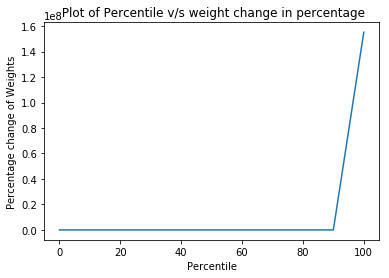

In [64]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

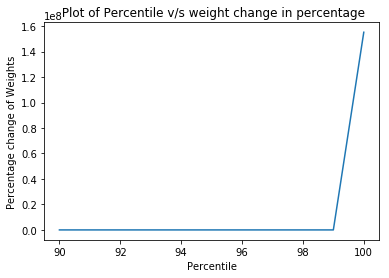

 Percentile : [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.55151569e+08]


In [65]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [66]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([2.20298392e+00, 3.28197134e+00, 5.04517593e+00, 8.70704002e+00,
       1.79676829e+01, 4.50960836e+01, 9.37459175e+01, 1.00339982e+02,
       3.77736495e+03, 1.55151569e+08])

# Observation: From above two graphs we see that, above 99.8 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [67]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.8 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.8 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.8 percentile is : 995
Top 10 features having weights change more than 99.8 percentile
(113487889.76757906, 'quanit')
(112286197.40512024, 'producto')
(68080604.84498827, 'materi')
(63359006.42865815, 'overton')
(60102799.452835776, 'timomthi')
(56589628.13715538, 'heartworm')
(45288346.93554065, 'outta')
(41436367.76800833, 'unread')
(39073747.42721999, 'muchwould')
(36874424.75931433, 'airlin')


In [68]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.100 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [50]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-19.1726	not worth      				15.8116	not disappoint 
	-17.3742	two star       				13.7163	delici         
	-13.0287	worst          				11.4933	great          
	-11.0008	not happi      				10.8853	love           
	-10.0164	horribl        				10.0969	excel          
	-9.2777	threw          				9.9427	good           
	-8.9945	avail cup      				9.1703	happi          
	-8.8923	disappoint     				8.6711	best           
	-8.6625	stale          				8.2831	perfect        
	-8.4920	not good       				8.0774	high recommend 
	-7.8829	anymor sure    				7.5543	right amount   
	-7.7495	wont buy       				7.4391	wont disappoint
	-7.6587	amaz though    				7.2500	refresh        
	-7.5868	terribl        				7.1211	not overpow    
	-7.3864	research cat   				6.8770	four star      
	-7.3567	everi case     				6.5087	tasti       

** Logistic Regression using Random Search and L2 penalty **

In [69]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain = maxscaler.fit_transform(tfidfVecTrain)
tfidfVecTest = maxscaler.transform(tfidfVecTest)

In [52]:
aucScore, optimalParam = clf(tfidfVecTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([35.27132435,  1.21379037, 37.99099746,  1.75116179, 32.42518582]),
 'std_fit_time': array([2.50035166, 0.01406023, 2.23789211, 0.04331621, 6.42420844]),
 'mean_score_time': array([0.01407325, 0.01093929, 0.00468514, 0.01406288, 0.00937331]),
 'std_score_time': array([0.00469112, 0.00716146, 0.00715667, 0.00468766, 0.00765327]),
 'param_C': masked_array(data=[10000, 1e-10, 10000000, 1e-08, 1000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000},
  {'C': 1e-10},
  {'C': 10000000},
  {'C': 1e-08},
  {'C': 1000000}],
 'split0_test_score': array([0.94912569, 0.91164172, 0.94844784, 0.91164172, 0.94850705]),
 'split1_test_score': array([0.9547414 , 0.9031177 , 0.95423055, 0.90311739, 0.95423363]),
 'split2_test_score': array([0.95787824, 0.91333049, 0.95758681, 0.91332988, 0.95757077]),
 'split3_test_score': array([0.96027231, 0.91879077, 0.96008187, 0.91878954, 0.96009683]),
 'spl

In [53]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10000


In [70]:
coef, classlabel = clfPerformance(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],tfidfVecTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
10000 		0.847 		97.371 		71.953


# To Test whether the features are Multicollinear using Pertubation Test

In [71]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

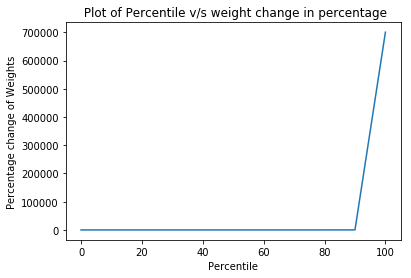

In [72]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

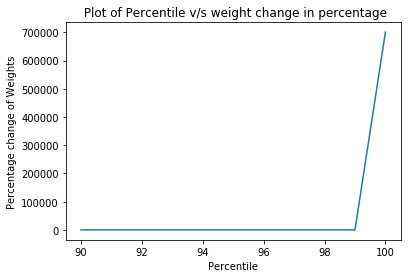

 Percentile : [5.01944168e-06 5.41770059e-01 1.06191944e+00 1.58616600e+00
 2.18886131e+00 2.98840504e+00 4.11283553e+00 6.06789335e+00
 9.90437465e+00 2.14319489e+01 7.00174297e+05]


In [73]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

# Observation: From above two graphs we see that, above 98 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [74]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,98))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 98 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 98 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 98 percentile is : 19879
Top 10 features having weights change more than 98 percentile
(83763.8033631193, 'scrunchd')
(83763.8033631193, 'buddhacook')
(56142.87185820035, 'fewyou')
(55829.15362611451, 'foreign')
(26138.811511936838, 'redbon')
(15690.813489679123, 'concern')
(15075.542858164275, 'cleanb')
(9947.761276554687, 'jordan')
(8225.177488711664, 'splci')
(8015.673828348471, 'htis')


In [75]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

1.999 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [56]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-14.3628	worst          				16.1971	great          
	-14.3102	disappoint     				15.8774	love           
	-12.9916	not good       				15.5241	delici         
	-12.0150	horribl        				14.6356	good           
	-11.6043	threw          				14.3377	not disappoint 
	-11.5938	terribl        				12.6997	excel          
	-10.7157	stale          				12.1523	best           
	-10.5143	not            				9.8004	awesom         
	-10.2199	gross          				9.1788	perfect        
	-10.0826	wont buy       				9.0247	wont disappoint
	-9.9236	not recommend  				8.8500	happi          
	-9.8636	aw             				8.3909	tasti          
	-9.4256	disgust        				8.2094	yummi          
	-9.0697	not worth      				8.1999	amaz           
	-9.0252	not buy        				7.9877	not bad        
	-8.9893	never buy      				7.8786	not b

** Logistic Regression using Random Search and L1 penalty **

In [76]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain = maxscaler.fit_transform(tfidfVecTrain)
tfidfVecTest = maxscaler.transform(tfidfVecTest)

In [58]:
aucScore, optimalParam = clf(tfidfVecTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([ 9.43059883, 10.36318595,  1.2091007 ,  9.52745771,  9.12442977]),
 'std_fit_time': array([0.43156557, 0.32122164, 0.0272368 , 0.7554216 , 0.31104473]),
 'mean_score_time': array([0.01405935, 0.01249526, 0.01406138, 0.01249409, 0.01249032]),
 'std_score_time': array([0.00468645, 0.00624763, 0.00468713, 0.00624705, 0.00624518]),
 'param_C': masked_array(data=[10000000000, 100000, 1e-08, 10, 100000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000000000},
  {'C': 100000},
  {'C': 1e-08},
  {'C': 10},
  {'C': 100000000}],
 'split0_test_score': array([0.75371612, 0.8075524 , 0.5       , 0.94532704, 0.74930376]),
 'split1_test_score': array([0.74449049, 0.7926261 , 0.5       , 0.94967602, 0.73851211]),
 'split2_test_score': array([0.73786279, 0.79667887, 0.5       , 0.95493338, 0.73042045]),
 'split3_test_score': array([0.7547406 , 0.81680454, 0.5       , 0.95575356, 0.76163661]),

In [59]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10


In [77]:
coef, classlabel = clfPerformance(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],tfidfVecTest,AmazonReviewDataSampledTest['Score'],10,'l1')

Optimal C 	AUC 		TPR 		TNR
10 		0.872 		95.488 		78.854


# To Test whether the features are Multicollinear using Pertubation Test

In [78]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=10)

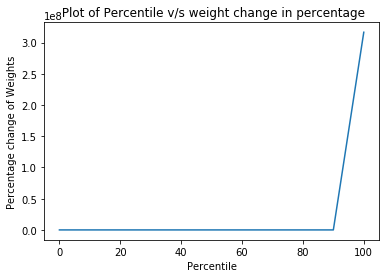

In [79]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

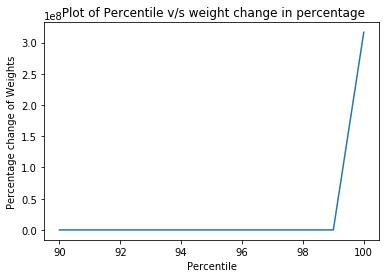

 Percentile : [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.16661734e+08]


In [80]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [81]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([5.75069097e+01, 7.76425195e+01, 9.51353731e+01, 9.99918821e+01,
       1.00006373e+02, 1.53955854e+02, 6.96040683e+02, 3.67934313e+04,
       1.97735220e+06, 3.16661734e+08])

# Observation: From above two graphs we see that, above 99.7 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [82]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.7))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.7 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.7 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.7 percentile is : 2984
Top 10 features having weights change more than 99.7 percentile
(158944101.20977053, 'camomill')
(134309720.16763625, 'siberian')
(128380914.11525291, 'hikerscamp')
(127844018.1116181, 'magarita')
(112077675.49880706, 'quickdraw')
(101029358.8442179, 'seconf')
(94144359.67409769, 'butteroil')
(79003180.86597861, 'lockhe')
(71145376.17350921, 'excellentmi')
(66336657.61167916, 'vacuumthre')


In [83]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.300 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [62]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-36.0823	not worth      				26.2635	not disappoint 
	-32.0804	two star       				22.8680	delici         
	-23.4468	worst          				19.0896	great          
	-19.8225	not happi      				18.4008	love           
	-16.6549	avail cup      				17.0070	good           
	-16.6391	horribl        				16.7612	excel          
	-16.3266	threw          				15.4484	happi          
	-15.8740	disappoint     				14.9076	right amount   
	-15.6423	stale          				14.4833	best           
	-15.5798	amaz though    				13.8759	improv also    
	-14.7177	not good       				13.7863	high recommend 
	-14.3219	wont buy       				12.9372	perfect        
	-13.8774	terribl        				12.6881	refresh        
	-13.7805	dont recommend 				12.2506	wont disappoint
	-13.6241	research cat   				12.0741	yummi          
	-13.3368	formula longer 		

# Program to Train and Test Logistic Regression Classifier using Word2Vec Vectorizer

** Logistic Regression using Grid Search and L2 penalty **

In [63]:
file1 = open('word2vectorsTrain','rb')
w2vTrain = pickle.load(file1)

file2 = open('word2vectorsTest','rb')
w2vTest = pickle.load(file2)

standScale = StandardScaler()
w2vTrain = standScale.fit_transform(w2vTrain)

w2vTest = standScale.fit_transform(w2vTest)

In [64]:
aucScore, optimalParam = clf(w2vTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([0.83729873, 1.96049023, 2.05265687, 2.15260723, 2.11982777,
        2.21510036, 2.11670256]),
 'std_fit_time': array([0.01036248, 0.05144526, 0.06334351, 0.0982509 , 0.1208183 ,
        0.12314224, 0.29134287]),
 'mean_score_time': array([0.00312433, 0.00624814, 0.00468342, 0.00156212, 0.00624833,
        0.        , 0.00156195]),
 'std_score_time': array([0.00624866, 0.00765238, 0.00715405, 0.00468636, 0.00765261,
        0.        , 0.00468585]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.88519365, 0.88908359, 0.88879509, 0.88873248, 0.88872893,
        0.88872755, 0.88872708]),
 'split1_test_score': array([0.88000908, 0.88457625, 0.8846535 , 0.88465042, 0.88465227,
      

In [65]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10


In [66]:
coef, classlabel = clfPerformance(w2vTrain,AmazonReviewDataSampledTrain['Score'],w2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
10 		0.500 		100.000 		0.000


** Logistic Regression using Grid Search and L1 penalty **

In [67]:
file1 = open('word2vectorsTrain','rb')
w2vTrain = pickle.load(file1)

file2 = open('word2vectorsTest','rb')
w2vTest = pickle.load(file2)

standScale = StandardScaler()
w2vTrain = standScale.fit_transform(w2vTrain)

w2vTest = standScale.fit_transform(w2vTest)

In [68]:
aucScore, optimalParam = clf(w2vTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([ 0.4139642 ,  4.13496971,  8.84009736, 10.32413952, 10.26164811,
         9.89612126,  8.42415655]),
 'std_fit_time': array([0.02901186, 0.83631862, 0.77935273, 0.72070988, 0.42473978,
        0.8098152 , 1.43920487]),
 'mean_score_time': array([0.00468628, 0.00624897, 0.00781806, 0.0015583 , 0.0046859 ,
        0.00312328, 0.00156219]),
 'std_score_time': array([0.00715842, 0.00765342, 0.00781807, 0.00467491, 0.00715783,
        0.00624657, 0.00468657]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.77448772, 0.88915406, 0.88890888, 0.88875145, 0.88872924,
        0.88872909, 0.88872832]),
 'split1_test_score': array([0.76399028, 0.88417888, 0.8846111 , 0.88464409, 0.88465366,

In [69]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [70]:
coef, classlabel = clfPerformance(w2vTrain,AmazonReviewDataSampledTrain['Score'],w2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.500 		100.000 		0.000


** Logistic Regression using Random Search and L2 penalty **

In [71]:
file1 = open('word2vectorsTrain','rb')
w2vTrain = pickle.load(file1)

file2 = open('word2vectorsTest','rb')
w2vTest = pickle.load(file2)

standScale = StandardScaler()
w2vTrain = standScale.fit_transform(w2vTrain)

w2vTest = standScale.fit_transform(w2vTest)

In [72]:
aucScore, optimalParam = clf(w2vTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([0.27495258, 2.10732787, 2.13229764, 2.1229526 , 2.03858881]),
 'std_fit_time': array([0.00766086, 0.11077088, 0.10738773, 0.11423622, 0.15132556]),
 'mean_score_time': array([0.00624893, 0.00468619, 0.00312102, 0.00937512, 0.00468647]),
 'std_score_time': array([0.00765334, 0.00715827, 0.00624204, 0.00765476, 0.00715871]),
 'param_C': masked_array(data=[1e-09, 10000000, 1, 10000000000, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-09},
  {'C': 10000000},
  {'C': 1},
  {'C': 10000000000},
  {'C': 100}],
 'split0_test_score': array([0.84778339, 0.88872708, 0.88873248, 0.88872708, 0.88872755]),
 'split1_test_score': array([0.84017036, 0.88465412, 0.88465042, 0.88465412, 0.88465458]),
 'split2_test_score': array([0.84592963, 0.89041169, 0.89040953, 0.89041169, 0.89041169]),
 'split3_test_score': array([0.86003406, 0.89956407, 0.89956422, 0.89956407, 0.89956361]),
 'split4_test_

In [73]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 100


In [74]:
coef, classlabel = clfPerformance(w2vTrain,AmazonReviewDataSampledTrain['Score'],w2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
100 		0.500 		100.000 		0.000


** Logistic Regression using Random Search and L1 penalty **

In [75]:
file1 = open('word2vectorsTrain','rb')
w2vTrain = pickle.load(file1)

file2 = open('word2vectorsTest','rb')
w2vTest = pickle.load(file2)

standScale = StandardScaler()
w2vTrain = standScale.fit_transform(w2vTrain)

w2vTest = standScale.fit_transform(w2vTest)

In [76]:
aucScore, optimalParam = clf(w2vTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([0.24682088, 1.03726785, 9.07286847, 9.10098872, 8.14026406]),
 'std_fit_time': array([0.01166869, 0.05464675, 0.44650509, 0.35404572, 2.13639657]),
 'mean_score_time': array([0.00624979, 0.00156312, 0.00156188, 0.00312583, 0.00156233]),
 'std_score_time': array([0.00765439, 0.00468936, 0.00468564, 0.00625167, 0.004687  ]),
 'param_C': masked_array(data=[1e-06, 0.001, 1000000000, 1, 100000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-06},
  {'C': 0.001},
  {'C': 1000000000},
  {'C': 1},
  {'C': 100000000}],
 'split0_test_score': array([0.5       , 0.88355192, 0.88872832, 0.8887516 , 0.88872863]),
 'split1_test_score': array([0.5       , 0.87706268, 0.88465381, 0.8846444 , 0.88465288]),
 'split2_test_score': array([0.5       , 0.88482944, 0.89041215, 0.89040583, 0.89041323]),
 'split3_test_score': array([0.5       , 0.89091376, 0.89956222, 0.89955821, 0.89956222]),
 'split4_t

In [77]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1000000000


In [78]:
coef, classlabel = clfPerformance(w2vTrain,AmazonReviewDataSampledTrain['Score'],w2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
1000000000 		0.500 		100.000 		0.000


# Program to Train and Test Logistic Regression Classifier using TFIDFW2V vectorizer

** Logistic Regression using Grid Search and L2 penalty **

In [79]:
file1 = open('tfidfweightedAvgWord2VecTrain','rb')
tfidfw2vTrain = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest','rb')
tfidfw2vTest = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain = standScale.fit_transform(tfidfw2vTrain)

tfidfw2vTest = standScale.fit_transform(tfidfw2vTest)

In [80]:
aucScore, optimalParam = clf(tfidfw2vTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([0.89978836, 2.16513026, 2.21512079, 2.21509547, 2.21823754,
        2.26976826, 2.15574977]),
 'std_fit_time': array([0.00765257, 0.0298037 , 0.06872744, 0.06122007, 0.04988372,
        0.08616195, 0.13198999]),
 'mean_score_time': array([0.00781043, 0.00468585, 0.00312405, 0.00156212, 0.00156236,
        0.00312428, 0.00156226]),
 'std_score_time': array([0.00781043, 0.00715776, 0.00624809, 0.00468636, 0.00468707,
        0.00624857, 0.00468678]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.85638914, 0.86200501, 0.86179545, 0.86175443, 0.86175228,
        0.86175197, 0.86175166]),
 'split1_test_score': array([0.84461232, 0.85352786, 0.85361359, 0.85365121, 0.85364983,
      

In [81]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [82]:
coef, classlabel = clfPerformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.787 		78.304 		79.193


** Logistic Regression using Grid Search and L1 penalty **

In [83]:
file1 = open('tfidfweightedAvgWord2VecTrain','rb')
tfidfw2vTrain = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest','rb')
tfidfw2vTest = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain = standScale.fit_transform(tfidfw2vTrain)

tfidfw2vTest = standScale.fit_transform(tfidfw2vTest)

In [84]:
aucScore, optimalParam = clf(tfidfw2vTrain, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([ 0.32179735,  7.78039994, 12.62202072, 13.31092925, 14.03419626,
        12.98600631, 11.34109635]),
 'std_fit_time': array([0.01739108, 1.72284604, 0.80992093, 0.52934768, 0.40442444,
        0.36808114, 2.53236771]),
 'mean_score_time': array([0.00468612, 0.00312946, 0.00781357, 0.00468626, 0.00468585,
        0.00469029, 0.00469074]),
 'std_score_time': array([0.00715816, 0.00625893, 0.00781358, 0.00715838, 0.00715776,
        0.00716455, 0.00716524]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.72041367, 0.86186962, 0.86181673, 0.86176338, 0.86175598,
        0.86175228, 0.86175258]),
 'split1_test_score': array([0.70956358, 0.85262858, 0.85358846, 0.85363965, 0.85365368,

In [85]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [86]:
coef, classlabel = clfPerformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.788 		78.319 		79.236


** Logistic Regression using Random Search and L2 penalty **

In [87]:
file1 = open('tfidfweightedAvgWord2VecTrain','rb')
tfidfw2vTrain = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest','rb')
tfidfw2vTest = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain = standScale.fit_transform(tfidfw2vTrain)

tfidfw2vTest = standScale.fit_transform(tfidfw2vTest)

In [88]:
aucScore, optimalParam = clf(tfidfw2vTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([3.26798298, 0.42802196, 0.3811682 , 0.2999274 , 2.96182168]),
 'std_fit_time': array([0.14717445, 0.00765509, 0.02538691, 0.04624114, 0.52324953]),
 'mean_score_time': array([0.00312471, 0.00468543, 0.00156233, 0.00312395, 0.00312288]),
 'std_score_time': array([0.00624943, 0.00715711, 0.004687  , 0.0062479 , 0.00624576]),
 'param_C': masked_array(data=[10000, 1e-07, 1e-09, 1e-10, 10000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000},
  {'C': 1e-07},
  {'C': 1e-09},
  {'C': 1e-10},
  {'C': 10000000}],
 'split0_test_score': array([0.86175166, 0.81079409, 0.8100655 , 0.81005687, 0.86175166]),
 'split1_test_score': array([0.85365168, 0.79621412, 0.79542108, 0.79541121, 0.85365168]),
 'split2_test_score': array([0.8587977 , 0.80328961, 0.80244292, 0.8024349 , 0.8587977 ]),
 'split3_test_score': array([0.87030683, 0.8229288 , 0.82216182, 0.82215611, 0.87030683]),
 'split4_test_

In [89]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10000


In [90]:
coef, classlabel = clfPerformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
10000 		0.787 		78.319 		79.172


** Logistic Regression using Random Search and L1 penalty **

In [91]:
file1 = open('tfidfweightedAvgWord2VecTrain','rb')
tfidfw2vTrain = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest','rb')
tfidfw2vTest = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain = standScale.fit_transform(tfidfw2vTrain)

tfidfw2vTest = standScale.fit_transform(tfidfw2vTest)

In [92]:
aucScore, optimalParam = clf(tfidfw2vTrain, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([ 0.36676321, 13.09379866, 12.70168514,  0.35148804,  7.3076633 ]),
 'std_fit_time': array([0.01155789, 0.59340091, 0.58833712, 0.01259413, 1.75631973]),
 'mean_score_time': array([0.00937071, 0.00468647, 0.0078053 , 0.0109309 , 0.00780876]),
 'std_score_time': array([0.00765115, 0.00715871, 0.0078053 , 0.00715596, 0.00780876]),
 'param_C': masked_array(data=[1e-09, 1000000, 1000000000, 1e-05, 0.01],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-09},
  {'C': 1000000},
  {'C': 1000000000},
  {'C': 1e-05},
  {'C': 0.01}],
 'split0_test_score': array([0.5       , 0.86175274, 0.86175274, 0.5       , 0.86186931]),
 'split1_test_score': array([0.5       , 0.85365214, 0.85365091, 0.5       , 0.85262827]),
 'split2_test_score': array([0.5       , 0.85879863, 0.85879909, 0.5       , 0.85856656]),
 'split3_test_score': array([0.5       , 0.87030498, 0.87030375, 0.5       , 0.86958812]),
 's

In [93]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1000000


In [94]:
coef, classlabel = clfPerformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
1000000 		0.787 		78.323 		79.172


# Improving TNR by using the summary column of the dataset to predict whether the review is positive or not alongwith text column of the dataset.

In [88]:
# Program to remove stopwords, punctuations, special characters and stemming each words. 
i = 0
positivewords = [] # list to store all the positive words in a review text.
negativewords = [] # list to store all the negative words in a review text.
filteredSentence = [] # list to store all the filtered review text.
for sentn in AmazonReviewDataSampled['Summary'].values:
    filteredSent = []
    sentn = HtmlTagREmover(sentn)
    for word in sentn.split():
        for cleanedWord in PuncRemover(word).split():
            if (cleanedWord.isalpha() & (len(cleanedWord) > 2)):
                if (cleanedWord.lower() not in stopWordsEnglish):
                    stemmerWord = snoBallStemmer.stem(cleanedWord.lower())
                    filteredSent.append(stemmerWord)
                    if (AmazonReviewDataSampled['Score'].values)[i] == 'positive':
                        positivewords.append(stemmerWord)
                    else:
                        negativewords.append(stemmerWord)
                else:
                    continue
            else:
                continue
    i += 1
    string1 =" ".join(filteredSent)
    filteredSentence.append(string1)

AmazonReviewDataSampled['Summary'] = filteredSentence# Replacing the original text of amazon review datatset with the filtered one.
AmazonReviewDataSampled['Summary'].head()

0                         excel tast qualiti
1                              limit varieti
2                       victor fli bag great
3                                 good coffe
4    one best tool tool chest deal morn sick
Name: Summary, dtype: object

In [116]:
AmazonReviewDataSampled.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,1,1234137600,excel tast qualiti,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,1,1285718400,limit varieti,candi good childhood favorit mani get bag piec...


In [91]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset based on time based splitting .
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

# BOW vectorizer

** Obtaining the bow vectors using the text and summary columns of the dataset.**

In [102]:
bowTrain_TS = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'] + AmazonReviewDataSampledTrain['Summary'])

In [103]:
bowTrain_TS

<70000x94040 sparse matrix of type '<class 'numpy.int64'>'
	with 2367041 stored elements in Compressed Sparse Row format>

In [104]:
bowTest_TS = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'] + AmazonReviewDataSampledTest['Summary'])

In [105]:
bowTest_TS 

<30000x94040 sparse matrix of type '<class 'numpy.int64'>'
	with 990089 stored elements in Compressed Sparse Row format>

# TFIDF Vectorizer

** Obtaining the TFIDF vectors using the text and summary columns of the dataset. **

In [106]:
tfidfVecTrain_TS = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'] + AmazonReviewDataSampledTrain['Summary'])

In [107]:
tfidfVecTrain_TS

<70000x1208766 sparse matrix of type '<class 'numpy.float64'>'
	with 5113434 stored elements in Compressed Sparse Row format>

In [108]:
tfidfVecTest_TS = tfidfVec.transform(AmazonReviewDataSampledTest['Text'] + AmazonReviewDataSampledTest['Summary'])

In [109]:
tfidfVecTest_TS

<30000x1208766 sparse matrix of type '<class 'numpy.float64'>'
	with 1808101 stored elements in Compressed Sparse Row format>

# Program to Train and Test the Naive Bayes Classifier using BOW Vectorizer

** Logistic Regression using GridSearch and L2 penalty **

In [232]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain_TS = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain_TS

# Initialising and obtaining the bag of words of the Test Dataset
bowTest_TS = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest_TS
maxscaler = MaxAbsScaler()
bowTrain_TS = maxscaler.fit_transform(bowTrain_TS)
bowTest_TS = maxscaler.transform(bowTest_TS)

In [111]:
aucScore, optimalParam = clf(bowTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([ 0.38895714,  0.66235483,  1.25281811,  2.30726247,  4.97851384,
        10.6131232 , 22.85867116]),
 'std_fit_time': array([0.02465095, 0.06017138, 0.07116625, 0.37098163, 0.24491572,
        1.02842873, 6.77052921]),
 'mean_score_time': array([0.00468612, 0.00781045, 0.00312381, 0.00625193, 0.00156224,
        0.        , 0.00624456]),
 'std_score_time': array([0.00715816, 0.00781045, 0.00624762, 0.00765703, 0.00468671,
        0.        , 0.007648  ]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.90009728, 0.92207456, 0.93145623, 0.92870257, 0.91176046,
        0.88478873, 0.85802039]),
 'split1_test_score': array([0.89602786, 0.91853943, 0.92796628, 0.92453524, 0.90682753,

In [112]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [97]:
coef, classlabel = clfPerformance(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],bowTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.879 		90.059 		85.817


# To Test whether the features are Multicollinear using Pertubation Test

In [98]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

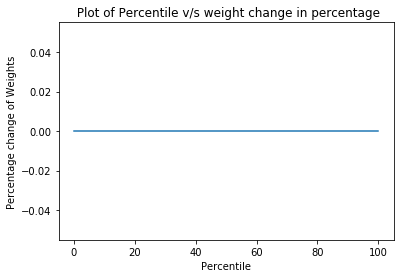

In [99]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

** None of the features are collinear. **

# Top Features in Positive and Negative Class

In [115]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-6.5650	not            				6.8538	great          
	-4.8051	disappoint     				6.0560	love           
	-3.9055	worst          				5.0075	delici         
	-3.4757	horribl        				4.9501	best           
	-3.3320	terribl        				4.0416	excel          
	-3.3240	aw             				3.9853	perfect        
	-3.2563	tast           				3.6410	good           
	-3.0828	return         				3.4585	nice           
	-2.9066	stale          				3.0858	favorit        
	-2.8410	bad            				2.7402	easi           
	-2.7672	didnt          				2.6425	wonder         
	-2.7057	threw          				2.5728	keep           
	-2.5597	money          				2.5335	happi          
	-2.4913	bland          				2.4334	awesom         
	-2.4189	unfortun       				2.4314	tasti          
	-2.3313	thought        				2.4201	thank          
	-2.31

** Logistic Regression using GridSearch and L1 penalty **

In [92]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain_TS = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain_TS

# Initialising and obtaining the bag of words of the Test Dataset
bowTest_TS = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest_TS
maxscaler = MaxAbsScaler()
bowTrain_TS = maxscaler.fit_transform(bowTrain_TS)
bowTest_TS = maxscaler.transform(bowTest_TS)

In [117]:
aucScore, optimalParam = clf(bowTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([2.15575886e-01, 5.24875593e-01, 5.60799479e-01, 1.29500790e+00,
        2.35568509e+00, 7.34827883e+00, 1.69052151e+03]),
 'std_fit_time': array([1.53050770e-02, 3.13948999e-02, 4.81259460e-02, 9.20153984e-02,
        2.25591938e-01, 2.77817609e+00, 3.89342180e+02]),
 'mean_score_time': array([0.00312421, 0.00312455, 0.        , 0.00312436, 0.        ,
        0.00155845, 0.0061337 ]),
 'std_score_time': array([0.00624843, 0.00624909, 0.        , 0.00624871, 0.        ,
        0.00467534, 0.00485086]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.5       , 0.85911419, 0.92138283, 0.92387805, 0.88980415,
        0.83789965, 0.82391196]),
 'split1_test_score': array([0.5       

In [118]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [93]:
coef, classlabel = clfPerformance(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],bowTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.873 		87.991 		86.603


# To Test whether the features are Multicollinear using Pertubation Test

In [94]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

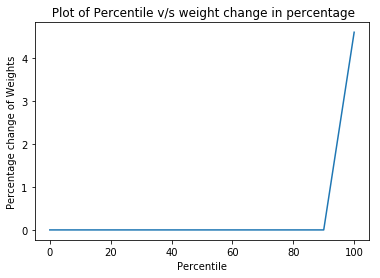

In [95]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

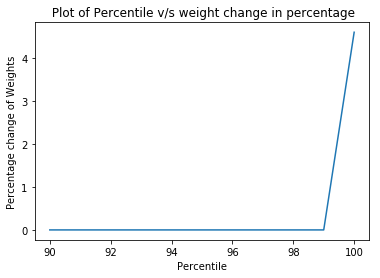

 Percentile : [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         4.60691296]


In [98]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [99]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([1.96170848e-03, 2.48164086e-03, 2.97263756e-03, 4.08594015e-03,
       5.14332187e-03, 6.47113673e-03, 9.34990631e-03, 1.45745246e-02,
       3.15538304e-02, 4.60691296e+00])

# Observation: From above two graphs we see that, above 99.9 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [242]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.9 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.9 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.9 percentile is : 43
Top 10 features having weights change more than 99.9 percentile
(25.812530498908437, 'summari')
(0.6395056276901252, 'versatil')
(0.4982913861202265, 'ounc')
(0.2778588136399657, 'expos')
(0.24166974141930725, 'perish')
(0.23225974778569403, 'fri')
(0.21860588125007413, 'yet')
(0.21687425734732468, 'teeth')
(0.1953404896363935, 'dri')
(0.17388250720630563, 'manag')


In [108]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

1.001 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [121]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-8.9685	not            				9.3278	love           
	-8.1423	worst          				9.1607	great          
	-6.1210	horribl        				8.4075	delici         
	-5.9071	disappoint     				7.6406	excel          
	-5.7794	return         				6.5778	best           
	-5.3399	terribl        				6.4308	perfect        
	-5.2398	tast           				5.2236	good           
	-5.0528	aw             				5.0626	nice           
	-4.9926	refund         				4.6985	keep           
	-4.6949	disgust        				4.5563	amaz           
	-4.6054	gross          				4.1171	yummi          
	-4.5151	stale          				4.0995	refresh        
	-4.3876	weak           				4.0144	happi          
	-4.3522	china          				3.9304	without        
	-4.3479	stick          				3.9160	favorit        
	-4.2680	ruin           				3.8520	year           
	-4.09

** Logistic Regression using Random Search and L2 penalty **


In [109]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain_TS = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain_TS

# Initialising and obtaining the bag of words of the Test Dataset
bowTest_TS = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest_TS
maxscaler = MaxAbsScaler()
bowTrain_TS = maxscaler.fit_transform(bowTrain_TS)
bowTest_TS = maxscaler.transform(bowTest_TS)

In [123]:
aucScore, optimalParam = clf(bowTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([ 0.26607461, 23.04783864,  0.25233302, 25.09816813, 22.94115317]),
 'std_fit_time': array([6.97108832e-02, 7.08835955e+00, 7.76282233e-03, 7.52634846e+00,
        7.91027004e+00]),
 'mean_score_time': array([0.00570254, 0.00387111, 0.00671916, 0.00424702, 0.0035512 ]),
 'std_score_time': array([0.0038371 , 0.00411325, 0.00823971, 0.00411634, 0.00444655]),
 'param_C': masked_array(data=[1e-06, 1000000, 1e-05, 10000, 10000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-06},
  {'C': 1000000},
  {'C': 1e-05},
  {'C': 10000},
  {'C': 10000000}],
 'split0_test_score': array([0.90662353, 0.85248672, 0.90502682, 0.85802039, 0.85709305]),
 'split1_test_score': array([0.90235026, 0.83402668, 0.90082879, 0.83105052, 0.83365722]),
 'split2_test_score': array([0.91136386, 0.84979582, 0.9089425 , 0.82703507, 0.81090295]),
 'split3_test_score': array([0.91705282, 0.87260314, 0.91477609, 0.8

In [124]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1e-06


In [110]:
coef, classlabel = clfPerformance(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],bowTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
1e-06 		0.500 		100.000 		0.000


# To Test whether the features are Multicollinear using Pertubation Test

In [111]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

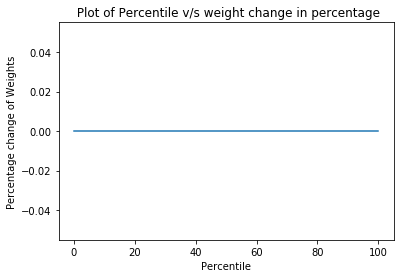

In [112]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

** None of the features are collinear. **

# Top Features in Positive and Negative Class 



In [127]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-0.0007	disappoint     				0.0008	great          
	-0.0006	not            				0.0005	love           
	-0.0004	wast           				0.0005	best           
	-0.0004	money          				0.0004	favorit        
	-0.0004	unfortun       				0.0004	delici         
	-0.0004	would          				0.0003	find           
	-0.0004	threw          				0.0003	perfect        
	-0.0004	bad            				0.0003	recommend      
	-0.0003	thought        				0.0003	easi           
	-0.0003	away           				0.0003	good           
	-0.0003	aw             				0.0003	enjoy          
	-0.0003	bought         				0.0003	nice           
	-0.0003	receiv         				0.0002	tasti          
	-0.0003	product        				0.0002	thank          
	-0.0003	hope           				0.0002	everi          
	-0.0003	didnt          				0.0002	wonder         
	-0.00

** Logistic Regression using Random Search and L1 penalty **

In [243]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain_TS = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain_TS

# Initialising and obtaining the bag of words of the Test Dataset
bowTest_TS = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest_TS
maxscaler = MaxAbsScaler()
bowTrain_TS = maxscaler.fit_transform(bowTrain_TS)
bowTest_TS = maxscaler.transform(bowTest_TS)

In [129]:
aucScore, optimalParam = clf(bowTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([1.64827189e+03, 1.76519942e-01, 8.53765168e+00, 1.59461702e+03,
        4.60816765e-01]),
 'std_fit_time': array([3.29983851e+02, 7.15795993e-03, 4.62791091e+00, 1.65778998e+02,
        2.54410497e-02]),
 'mean_score_time': array([0.00156164, 0.00468581, 0.00624807, 0.00468547, 0.00468981]),
 'std_score_time': array([0.00468493, 0.00715769, 0.00765229, 0.00715718, 0.00716381]),
 'param_C': masked_array(data=[1000, 1e-09, 100, 100000000, 0.01],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1000},
  {'C': 1e-09},
  {'C': 100},
  {'C': 100000000},
  {'C': 0.01}],
 'split0_test_score': array([0.82620703, 0.5       , 0.83796611, 0.79780127, 0.85911573]),
 'split1_test_score': array([0.79813249, 0.5       , 0.8230961 , 0.77514383, 0.86217216]),
 'split2_test_score': array([0.82579039, 0.5       , 0.84723815, 0.791533  , 0.86338075]),
 'split3_test_score': array([0.8230648 , 0.5       , 0.

In [130]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.01


In [244]:
coef, classlabel = clfPerformance(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],bowTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.01 		0.806 		82.337 		78.811


# To Test whether the features are Multicollinear using Pertubation Test

In [245]:
weightsWithoutPert = coef[0]
weightsWithoutPert += 10 ** (-6)
bowTrain.data += 0.01
percentageChange = PertubationTest(bowTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= bagOfWordsVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

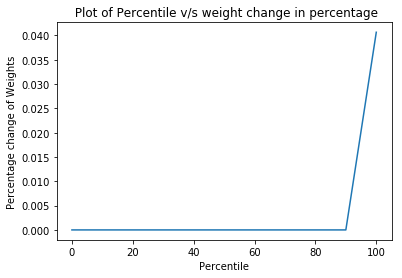

In [246]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

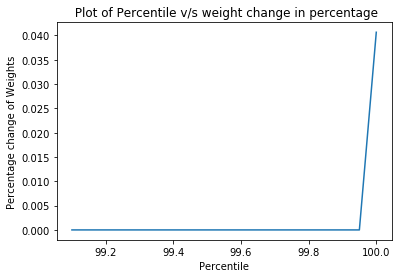

 Percentile : [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04065899]


In [247]:
percentileList1 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,99.95,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [250]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00036385, 0.04065899])

# Observation: From above two graphs we see that, above 99.9 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [251]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.9 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.9 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.9 percentile is : 43
Top 10 features having weights change more than 99.9 percentile
(0.04065898760044079, 'someth')
(0.03661748086252538, 'even')
(0.0345491086042839, 'wrong')
(0.013520694969393855, 'carri')
(0.013061518510348714, 'keep')
(0.00959371518131475, 'look')
(0.009018542978561375, 'satisfi')
(0.008480215987599772, 'make')
(0.007202693912143522, 'littl')
(0.004743238325547654, 'excit')


In [125]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.166 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [136]:
TopFeatures(numoffeat= 25, vectorizer= bagOfWordsVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-6.6804	not            				7.2564	great          
	-4.8952	disappoint     				6.3526	love           
	-2.8467	bad            				4.7645	delici         
	-2.3283	horribl        				4.6396	best           
	-2.2702	aw             				3.2572	perfect        
	-2.0458	worst          				2.7620	favorit        
	-2.0301	thought        				2.7538	good           
	-2.0008	money          				2.5094	nice           
	-1.8669	threw          				2.2818	excel          
	-1.8236	tast           				2.0427	easi           
	-1.8225	didnt          				1.6060	find           
	-1.8031	terribl        				1.5610	tasti          
	-1.7977	return         				1.5088	enjoy          
	-1.7751	unfortun       				1.3211	wonder         
	-1.7630	wast           				1.1607	thank          
	-1.6032	product        				1.1534	recommend      
	-1.34

# Program to Train and Test the Logistic Regression Classifier using TFIDF Vectorizer

** Logistic Regression using GridSearch and L2 penalty **

In [259]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain_TS = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest_TS = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain_TS = maxscaler.fit_transform(tfidfVecTrain_TS)
tfidfVecTest_TS = maxscaler.transform(tfidfVecTest_TS)

In [139]:
aucScore, optimalParam = clf(tfidfVecTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([ 10.78431473,  24.63821707,  40.85558734,  75.30992985,
        101.76744192, 123.63588865, 111.89432247]),
 'std_fit_time': array([ 0.32292396,  0.47872474,  0.92952579,  6.99621067,  3.4596146 ,
         6.03318369, 22.54425486]),
 'mean_score_time': array([0.04197559, 0.04476371, 0.04268863, 0.0407686 , 0.03877318,
        0.04588528, 0.02669287]),
 'std_score_time': array([0.01227845, 0.00827326, 0.0070823 , 0.00778055, 0.0070096 ,
        0.01210349, 0.02153272]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.91053428, 0.93612717, 0.9469199 , 0.94943193, 0.9496842 ,
        0.94966831, 0.94912569]),
 'split1_test_score': array([0.90192128, 0.9357002 , 0.95083497, 0.9545370

In [140]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10


In [260]:
coef, classlabel = clfPerformance(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfVecTest_TS,AmazonReviewDataSampledTest['Score'],10,'l2')

Optimal C 	AUC 		TPR 		TNR
10 		0.862 		96.647 		75.817


# To Test whether the features are Multicollinear using Pertubation Test

In [261]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=10)

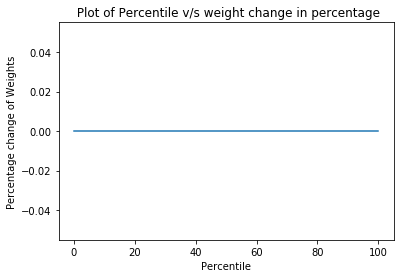

In [262]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

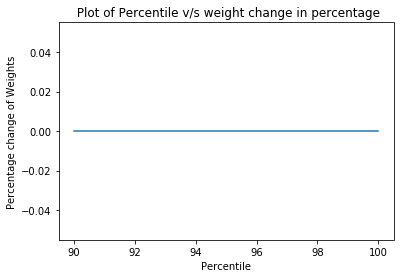

 Percentile : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [258]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [132]:
percentileList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentileList2)
percentile

array([   4.12048167,    4.62478416,    5.21089501,    6.30856596,
          7.48616863,    8.72963697,   11.49660976,   18.46561102,
         33.71044788, 2219.78142863])

# Observation: From above two graphs we see that, above 99.9 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [252]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.9 percentile is :" #%r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.9 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99 percentile is :


In [136]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.100 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [143]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-8.1386	disappoint     				10.2929	great          
	-7.4948	worst          				9.8362	love           
	-6.5118	not good       				8.6296	delici         
	-6.3862	terribl        				8.0137	good           
	-6.3667	horribl        				7.9220	best           
	-6.3154	not            				6.8332	excel          
	-5.9242	threw          				6.6848	not disappoint 
	-5.5914	not recommend  				6.5943	perfect        
	-5.5504	aw             				5.2605	nice           
	-5.5207	stale          				5.0569	high recommend 
	-5.0985	return         				5.0299	awesom         
	-4.8630	gross          				4.9870	favorit        
	-4.8145	wont buy       				4.8187	happi          
	-4.8052	disgust        				4.6788	amaz           
	-4.7501	not buy        				4.6221	tasti          
	-4.6498	weak           				4.4274	wonder         
	-4.6

# ** Logistic Regression using GridSearch and L1 penalty **

In [100]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain_TS = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest_TS = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain_TS = maxscaler.fit_transform(tfidfVecTrain_TS)
tfidfVecTest_TS = maxscaler.transform(tfidfVecTest_TS)

In [167]:
aucScore, optimalParam = clf(tfidfVecTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([ 4.98883693, 21.27126119, 26.25259058, 37.28231728, 44.92890821,
        39.16353374, 32.56405177]),
 'std_fit_time': array([0.2155163 , 2.61744053, 0.76720972, 1.21032754, 1.54394971,
        0.98924419, 7.50169656]),
 'mean_score_time': array([0.03187263, 0.04036422, 0.04023604, 0.04752681, 0.03644025,
        0.03373582, 0.02011049]),
 'std_score_time': array([0.00855009, 0.00661   , 0.00758888, 0.01128834, 0.00800421,
        0.00476205, 0.0061828 ]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.5       , 0.87852108, 0.93897442, 0.94742629, 0.94531162,
        0.9454797 , 0.90572641]),
 'split1_test_score': array([0.5       , 0.87816966, 0.94363673, 0.95323521, 0.94968851,

In [168]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1


In [101]:
coef, classlabel = clfPerformance(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfVecTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
1 		0.886 		94.401 		82.887


# To Test whether the features are Multicollinear using Pertubation Test

In [102]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

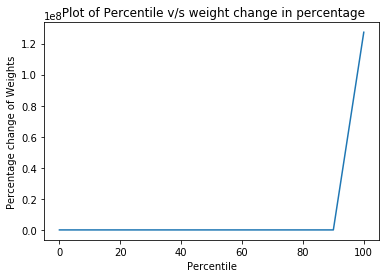

In [103]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

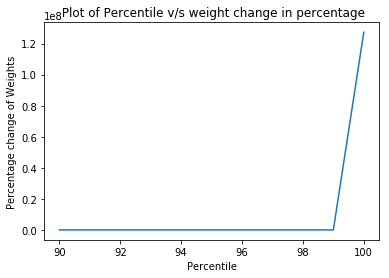

 Percentile : [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.27276655e+08]


In [104]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [105]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([6.97249788e-02, 1.16924927e-01, 2.01041670e-01, 3.69112419e-01,
       9.65969962e-01, 1.35767209e+01, 7.70941760e+01, 1.00008310e+02,
       1.19136492e+03, 1.27276655e+08])

# Observation: From above two graphs we see that, above 99.8 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [106]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.8))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.8 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.8 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.8 percentile is : 1989
Top 10 features having weights change more than 99.8 percentile
(94967167.95100465, 'detritus')
(87983862.46931991, 'packeg')
(57892817.05591339, 'crackersbut')
(30734678.889574066, 'pricehowev')
(28413147.024678078, 'theft')
(27582104.70926386, 'heartworm')
(26341957.583668064, 'normhigh')
(25233816.4274244, 'palpabl')
(24483426.524598375, 'batchchil')
(23812730.819124203, 'airless')


In [107]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.200 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [171]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-19.1748	not worth      				15.8110	not disappoint 
	-17.3609	two star       				13.7160	delici         
	-13.0292	worst          				11.4947	great          
	-11.0032	not happi      				10.8832	love           
	-10.0172	horribl        				10.0963	excel          
	-9.2785	threw          				9.9402	good           
	-8.9949	avail cup      				9.1707	happi          
	-8.8929	disappoint     				8.6694	best           
	-8.6664	stale          				8.2848	perfect        
	-8.4933	not good       				8.0790	high recommend 
	-7.8806	anymor sure    				7.5555	right amount   
	-7.7479	wont buy       				7.4404	wont disappoint
	-7.6575	amaz though    				7.2492	refresh        
	-7.5872	terribl        				7.1197	not overpow    
	-7.3827	research cat   				6.8795	four star      
	-7.3693	condit strong  				6.5103	tasti       

** Logistic Regression using Random Search and L2 penalty **

In [145]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain_TS = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest_TS = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain_TS = maxscaler.fit_transform(tfidfVecTrain_TS)
tfidfVecTest_TS = maxscaler.transform(tfidfVecTest_TS)

In [145]:
aucScore, optimalParam = clf(tfidfVecTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([137.59584208, 139.63485467,   6.29227881,  70.20951643,
         30.86798019]),
 'std_fit_time': array([7.82660974, 8.56873111, 0.14814192, 6.9532791 , 9.55167595]),
 'mean_score_time': array([0.0438803 , 0.04818499, 0.03802977, 0.0335551 , 0.01875236]),
 'std_score_time': array([0.00633284, 0.01010826, 0.00728478, 0.01442729, 0.01477534]),
 'param_C': masked_array(data=[10000000, 1000, 1e-07, 1, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000000}, {'C': 1000}, {'C': 1e-07}, {'C': 1}, {'C': 0.1}],
 'split0_test_score': array([0.94844784, 0.9498148 , 0.91163617, 0.94943193, 0.9469199 ]),
 'split1_test_score': array([0.95423055, 0.95515064, 0.903114  , 0.95453709, 0.95083497]),
 'split2_test_score': array([0.95758681, 0.95815472, 0.91331955, 0.95823505, 0.95554015]),
 'split3_test_score': array([0.96008187, 0.96103497, 0.9187809 , 0.9608655 , 0.95801964]),
 'split4_test_scor

In [146]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1000


In [146]:
coef, classlabel = clfPerformance(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfVecTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
1000 		0.854 		97.062 		73.800


# To Test whether the features are Multicollinear using Pertubation Test

In [147]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l2',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

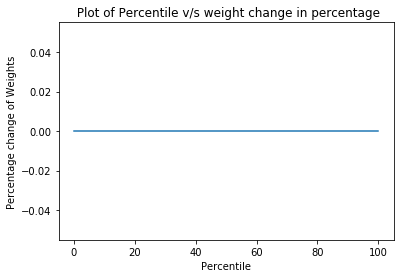

In [148]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

** None of the features are collinear. **

# Top Features in Positive and Negative Class

In [149]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-13.1721	disappoint     				16.2060	great          
	-12.5730	worst          				15.7080	love           
	-11.0974	not good       				14.1843	delici         
	-10.6872	horribl        				13.2318	good           
	-10.4731	terribl        				12.4256	best           
	-10.0212	threw          				11.8894	not disappoint 
	-9.9372	not            				11.2285	excel          
	-9.4405	stale          				9.9342	perfect        
	-9.1455	not recommend  				8.4112	awesom         
	-8.8533	aw             				8.1311	nice           
	-8.6166	gross          				7.9161	happi          
	-8.3694	wont buy       				7.5980	tasti          
	-8.0194	disgust        				7.5412	favorit        
	-8.0194	not buy        				7.5242	wont disappoint
	-7.9237	return         				7.5092	amaz           
	-7.7324	nasti          				7.4069	high reco

** Logistic Regression using Random Search and L1 penalty **

In [108]:
# Initialising and obtaining the bag of words of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain_TS = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

# Initialising and obtaining the bag of words of the Test Dataset
tfidfVecTest_TS = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])

#Performing Column standardization using MaxAbsScaler best suited for sparse matrices
maxscaler = MaxAbsScaler()
tfidfVecTrain_TS = maxscaler.fit_transform(tfidfVecTrain_TS)
tfidfVecTest_TS = maxscaler.transform(tfidfVecTest_TS)

In [173]:
aucScore, optimalParam = clf(tfidfVecTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([37.69891493, 24.45984635,  4.88642118,  4.76869633, 24.14773397]),
 'std_fit_time': array([0.56280022, 1.02904186, 0.14563243, 0.08147201, 1.87736284]),
 'mean_score_time': array([0.04169722, 0.04437621, 0.03354542, 0.03139014, 0.0328197 ]),
 'std_score_time': array([0.00712733, 0.01589551, 0.00470309, 0.0097064 , 0.01801979]),
 'param_C': masked_array(data=[10000000000, 0.1, 1e-05, 1e-07, 0.01],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000000000},
  {'C': 0.1},
  {'C': 1e-05},
  {'C': 1e-07},
  {'C': 0.01}],
 'split0_test_score': array([0.75061228, 0.93897273, 0.5       , 0.5       , 0.87852185]),
 'split1_test_score': array([0.73883947, 0.94363766, 0.5       , 0.5       , 0.87816951]),
 'split2_test_score': array([0.73262871, 0.94923394, 0.5       , 0.5       , 0.87719459]),
 'split3_test_score': array([0.75703583, 0.9515045 , 0.5       , 0.5       , 0.88415012]),
 'split4_

In [174]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [109]:
coef, classlabel = clfPerformance(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfVecTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.892 		89.134 		89.193


# To Test whether the features are Multicollinear using Pertubation Test

In [110]:
weightsWithoutPert = coef[0] # weights before pertubation
weightsWithoutPert += 10 ** (-6) # to avoid divide by zero
tfidfVecTrain.data += 0.01 # adding small noise to train dataset.
percentageChange = PertubationTest(tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],regularizer= 'l1',vectorizer= tfidfVec,weights = weightsWithoutPert,optimal_param=optimalParam[0])

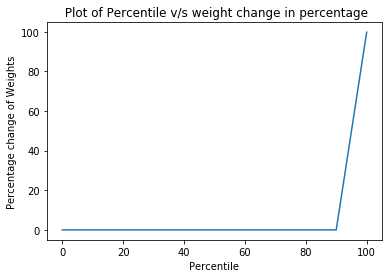

In [111]:
percentileList = [0,10,20,30,40,50,60,70,80,90,100]
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()

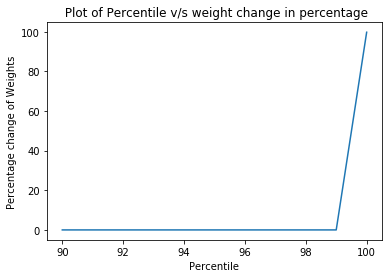

 Percentile : [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         99.75973453]


In [112]:
percentileList1 = np.arange(90,101,1)
percentile = np.percentile(percentageChange,percentileList)
plt.plot(percentileList1,percentile)
plt.xlabel('Percentile')
plt.ylabel('Percentage change of Weights')
plt.title(' Plot of Percentile v/s weight change in percentage')
plt.show()
print(" Percentile : %s" %percentile)

In [113]:
percentList2 = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
percentile = np.percentile(percentageChange,percentList2)
percentile

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 99.75973453])

# Observation: From above two graphs we see that, above 99.9 percentile, there is a vast change in the weights, hence threshold is taken as the change of weights above 99 percentile. 

In [114]:
numOfFeatures = percentageChange[np.where(percentageChange > np.percentile(percentageChange,99.9))].size # determining the number of features whose percentage change is more than 30%
print("Number of features whose weights are changed more than 99.9 percentile is : %r" % (numOfFeatures))
feature_names = bagOfWordsVec.get_feature_names() # obtaining the feature names for a particular vectorizer.
coefs_with_fns = sorted(zip(percentageChange, feature_names), reverse = True) # assigning each weights with its corresponding feature names
print('Top 10 features having weights change more than 99.9 percentile')
for x in range(10):
    print(coefs_with_fns[x])

Number of features whose weights are changed more than 99.9 percentile is : 856
Top 10 features having weights change more than 99.9 percentile
(0.42658945791986813, 'tariff')
(0.30780073045698997, 'scovial')
(0.11957197506700247, 'sqeezeabl')
(0.0981611270114982, 'medusa')
(0.07505236559787919, 'teast')
(0.0655149785077942, 'patrol')
(0.03424239732506367, 'seltzer')
(0.02414766763757884, 'gnf')
(0.0223327528194175, 'acquir')
(0.02148421809198177, 'mixerwa')


In [115]:
print( "%.3f percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class"% ((numOfFeatures / len(percentageChange) * 100)))

0.086 percentage of features are collinear. Hence we can use the weigths to obtain the important features for positive and negative class


# Top Features in Positive and Negative Class

In [177]:
TopFeatures(numoffeat= 25, vectorizer= tfidfVec,coef = coef[0])

25 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-7.5777	worst          				8.9183	delici         
	-5.8823	disappoint     				8.6320	not disappoint 
	-5.5189	horribl        				7.7968	great          
	-5.2945	not worth      				7.2146	love           
	-4.9300	threw          				7.0300	excel          
	-4.8717	two star       				5.6865	perfect        
	-4.8126	wont buy       				5.5995	best           
	-4.6178	not good       				5.3908	good           
	-4.6032	terribl        				5.2074	high recommend 
	-4.5145	aw             				4.7447	happi          
	-4.3618	disgust        				4.0470	awesom         
	-4.2688	stale          				3.9872	nice           
	-3.9015	gross          				3.9515	wont disappoint
	-3.8978	refund         				3.9123	yummi          
	-3.8266	return         				3.7511	tasti          
	-3.7381	not recommend  				3.6335	favorit        
	-3.73

# Program to Train and Test Logistic Regression Classifier using Word2Vec Vectorizer

** Logistic Regression using Grid Search and L2 penalty **

In [150]:
file1 = open('word2vectorsTrain_TS','rb')
w2vTrain_TS = pickle.load(file1)

file2 = open('word2vectorsTest_TS','rb')
w2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
w2vTrain_TS = standScale.fit_transform(w2vTrain_TS)

w2vTest_TS = standScale.fit_transform(w2vTest_TS)

In [151]:
aucScore, optimalParam = clf(w2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([2.52922404, 6.08191483, 6.77465239, 6.75448189, 6.82938743,
        6.72073176, 6.15804186]),
 'std_fit_time': array([0.07322966, 0.17068349, 0.17394259, 0.24042897, 0.28912055,
        0.2365028 , 0.41136512]),
 'mean_score_time': array([0.00781598, 0.00941629, 0.01336446, 0.01133528, 0.00468764,
        0.00624828, 0.00698524]),
 'std_score_time': array([0.00781598, 0.00768863, 0.00715698, 0.0105237 , 0.00716049,
        0.00765255, 0.00856179]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.88339186, 0.88652052, 0.88628907, 0.88623279, 0.88623325,
        0.88623294, 0.88623341]),
 'split1_test_score': array([0.8812388 , 0.88559071, 0.88567182, 0.88569557, 0.88569325,
      

In [152]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1


In [153]:
coef, classlabel = clfPerformance(w2vTrain_TS,AmazonReviewDataSampledTrain['Score'],w2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
1 		0.505 		74.618 		26.285


** Logistic Regression using Grid Search and L1 penalty **

In [178]:
file1 = open('word2vectorsTrain_TS','rb')
w2vTrain_TS = pickle.load(file1)

file2 = open('word2vectorsTest_TS','rb')
w2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
w2vTrain_TS = standScale.fit_transform(w2vTrain_TS)

w2vTest_TS = standScale.fit_transform(w2vTest_TS)

In [179]:
aucScore, optimalParam = clf(w2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([ 1.63957515, 23.41102469, 36.99976037, 38.42450607, 37.656615  ,
        36.9136709 , 32.67482181]),
 'std_fit_time': array([0.08229973, 2.04347883, 1.52328712, 0.90418421, 1.68141935,
        1.30841103, 5.96731664]),
 'mean_score_time': array([0.04128594, 0.01579065, 0.01562605, 0.01349533, 0.01590719,
        0.01562383, 0.00539279]),
 'std_score_time': array([2.11133595e-02, 1.05076568e-02, 8.47121040e-06, 6.47599638e-03,
        6.37351336e-03, 8.14572001e-06, 7.00985424e-03]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.79047968, 0.88663432, 0.88634242, 0.88623695, 0.88623186,
        0.88623233, 0.88623217]),
 'split1_test_score': array([0.78123169, 0.88534477, 0.88568

In [180]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10


In [181]:
coef, classlabel = clfPerformance(w2vTrain_TS,AmazonReviewDataSampledTrain['Score'],w2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
10 		0.504 		74.595 		26.263


** Logistic Regression using Random Search and L2 penalty **

In [154]:
file1 = open('word2vectorsTrain_TS','rb')
w2vTrain_TS = pickle.load(file1)

file2 = open('word2vectorsTest_TS','rb')
w2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
w2vTrain_TS = standScale.fit_transform(w2vTrain_TS)

w2vTest_TS = standScale.fit_transform(w2vTest_TS)

In [155]:
aucScore, optimalParam = clf(w2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([6.72482159, 6.72135222, 6.79859381, 5.50197566, 0.56227248]),
 'std_fit_time': array([0.22714996, 0.23387116, 0.30192857, 1.55749409, 0.0638854 ]),
 'mean_score_time': array([0.00468667, 0.00937514, 0.01305397, 0.00856497, 0.007342  ]),
 'std_score_time': array([0.007159  , 0.00765477, 0.00663672, 0.00737205, 0.00792299]),
 'param_C': masked_array(data=[100, 100000000, 1000, 1000000, 1e-10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100},
  {'C': 100000000},
  {'C': 1000},
  {'C': 1000000},
  {'C': 1e-10}],
 'split0_test_score': array([0.88623294, 0.88623356, 0.88623341, 0.88623356, 0.85609755]),
 'split1_test_score': array([0.88569387, 0.88569387, 0.88569372, 0.88569387, 0.85383687]),
 'split2_test_score': array([0.88837922, 0.88837922, 0.88837937, 0.88837922, 0.85819741]),
 'split3_test_score': array([0.90058285, 0.90058347, 0.90058331, 0.90058347, 0.86731803]),
 'split4_test_

In [156]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1000


In [157]:
coef, classlabel = clfPerformance(w2vTrain_TS,AmazonReviewDataSampledTrain['Score'],w2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
1000 		0.504 		74.583 		26.285


** Logistic Regression using Random Search and L1 penalty **

In [182]:
file1 = open('word2vectorsTrain_TS','rb')
w2vTrain_TS = pickle.load(file1)

file2 = open('word2vectorsTest_TS','rb')
w2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
w2vTrain_TS = standScale.fit_transform(w2vTrain_TS)

w2vTest_TS = standScale.fit_transform(w2vTest_TS)

In [183]:
aucScore, optimalParam = clf(w2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([36.77262955, 37.68431275,  0.90522792, 28.75263622,  4.35514424]),
 'std_fit_time': array([1.05226858, 0.86645581, 0.08616931, 7.41527379, 0.33281435]),
 'mean_score_time': array([0.01496794, 0.01093678, 0.01118054, 0.00458143, 0.01159468]),
 'std_score_time': array([0.00659742, 0.00715981, 0.00735285, 0.00700356, 0.0072313 ]),
 'param_C': masked_array(data=[1000, 100000000, 1e-07, 1, 0.001],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1000},
  {'C': 100000000},
  {'C': 1e-07},
  {'C': 1},
  {'C': 0.001}],
 'split0_test_score': array([0.88623294, 0.88623264, 0.5       , 0.88623664, 0.88253745]),
 'split1_test_score': array([0.88569433, 0.8856948 , 0.5       , 0.88569464, 0.88056141]),
 'split2_test_score': array([0.88837582, 0.88837598, 0.5       , 0.88837814, 0.88401204]),
 'split3_test_score': array([0.90058069, 0.90058085, 0.5       , 0.90057391, 0.89342424]),
 'split4_test_sco

In [184]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 100000000


In [185]:
coef, classlabel = clfPerformance(w2vTrain_TS,AmazonReviewDataSampledTrain['Score'],w2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
100000000 		0.504 		74.599 		26.263


# Program to Train and Test Logistic Regression Classifier using TFIDFW2V vectorizer

** Logistic Regression using Grid Search and L2 penalty **

In [158]:
file1 = open('tfidfweightedAvgWord2VecTrain_TS','rb')
tfidfw2vTrain_TS = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest_TS','rb')
tfidfw2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain_TS = standScale.fit_transform(tfidfw2vTrain_TS)

tfidfw2vTest_TS = standScale.fit_transform(tfidfw2vTest_TS)

In [159]:
aucScore, optimalParam = clf(tfidfw2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l2')
aucScore

{'mean_fit_time': array([2.7344399 , 6.43690915, 6.84279797, 6.84812565, 6.80092096,
        6.79829555, 6.19794166]),
 'std_fit_time': array([0.09404879, 0.12888131, 0.12932013, 0.11679368, 0.12736441,
        0.14085528, 0.22975839]),
 'mean_score_time': array([0.01153195, 0.01249654, 0.00781302, 0.00957417, 0.00937312,
        0.0090553 , 0.00256009]),
 'std_score_time': array([0.00644187, 0.00624827, 0.00781303, 0.00783816, 0.00765312,
        0.00888189, 0.00560179]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.85275209, 0.85803335, 0.85781593, 0.85777044, 0.85776396,
        0.85776427, 0.85776443]),
 'split1_test_score': array([0.84342115, 0.85275487, 0.85287807, 0.85289179, 0.85289133,
      

In [160]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 0.1


In [161]:
coef, classlabel = clfPerformance(tfidfw2vTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
0.1 		0.512 		71.036 		31.423


** Logistic Regression using Grid Search and L1 penalty **

In [186]:
file1 = open('tfidfweightedAvgWord2VecTrain_TS','rb')
tfidfw2vTrain_TS = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest_TS','rb')
tfidfw2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain_TS = standScale.fit_transform(tfidfw2vTrain_TS)

tfidfw2vTest_TS = standScale.fit_transform(tfidfw2vTest_TS)

In [187]:
aucScore, optimalParam = clf(tfidfw2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'GridSearch','l1')
aucScore

{'mean_fit_time': array([ 1.40744541, 17.71241786, 29.38045473, 32.28422348, 30.36222749,
        28.25828793, 25.93108039]),
 'std_fit_time': array([0.03611914, 1.2840625 , 0.60980531, 2.15512919, 1.60647529,
        0.9020219 , 3.08506115]),
 'mean_score_time': array([0.01093638, 0.01565788, 0.01718416, 0.01406522, 0.01602261,
        0.01562493, 0.00533221]),
 'std_score_time': array([7.15954128e-03, 9.90383115e-05, 4.68694486e-03, 4.68841174e-03,
        1.18902762e-03, 7.80401226e-06, 7.51188077e-03]),
 'param_C': masked_array(data=[0.0001, 0.01, 0.1, 1, 10, 100, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 10000}],
 'split0_test_score': array([0.7229735 , 0.85822162, 0.85785016, 0.85777337, 0.85776643,
        0.85776443, 0.85776458]),
 'split1_test_score': array([0.70502416, 0.85238078, 0.85286

In [188]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 10


In [189]:
coef, classlabel = clfPerformance(tfidfw2vTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
10 		0.512 		70.989 		31.486


** Logistic Regression using Random Search and L2 penalty **

In [162]:
file1 = open('tfidfweightedAvgWord2VecTrain_TS','rb')
tfidfw2vTrain_TS = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest_TS','rb')
tfidfw2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain_TS = standScale.fit_transform(tfidfw2vTrain_TS)

tfidfw2vTest_TS = standScale.fit_transform(tfidfw2vTest_TS)

In [163]:
aucScore, optimalParam = clf(tfidfw2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l2')
aucScore

{'mean_fit_time': array([2.7319535 , 4.83709958, 6.86437299, 6.78256142, 5.36845102]),
 'std_fit_time': array([0.09653231, 0.1322655 , 0.18444325, 0.15680282, 1.53274174]),
 'mean_score_time': array([0.00666904, 0.00636826, 0.00624907, 0.00809615, 0.0035727 ]),
 'std_score_time': array([0.00801746, 0.00780606, 0.00765352, 0.00813578, 0.00714651]),
 'param_C': masked_array(data=[0.0001, 0.001, 100, 1000, 1000000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 100},
  {'C': 1000},
  {'C': 1000000}],
 'split0_test_score': array([0.85275209, 0.85790906, 0.85776427, 0.85776443, 0.85776443]),
 'split1_test_score': array([0.84342115, 0.85123201, 0.85289118, 0.85289118, 0.85289118]),
 'split2_test_score': array([0.85029557, 0.85475311, 0.8547767 , 0.85477608, 0.85477608]),
 'split3_test_score': array([0.86391798, 0.86934202, 0.87011671, 0.87011702, 0.87011702]),
 'split4_test_score'

In [164]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 100


In [165]:
coef, classlabel = clfPerformance(tfidfw2vTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l2')

Optimal C 	AUC 		TPR 		TNR
100 		0.512 		70.973 		31.486


** Logistic Regression using Random Search and L1 penalty **

In [190]:
file1 = open('tfidfweightedAvgWord2VecTrain_TS','rb')
tfidfw2vTrain_TS = pickle.load(file1)

file2 = open('tfidfweightedAvgWord2VecTest_TS','rb')
tfidfw2vTest_TS = pickle.load(file2)

standScale = StandardScaler()
tfidfw2vTrain_TS = standScale.fit_transform(tfidfw2vTrain_TS)

tfidfw2vTest_TS = standScale.fit_transform(tfidfw2vTest_TS)

In [191]:
aucScore, optimalParam = clf(tfidfw2vTrain_TS, AmazonReviewDataSampledTrain['Score'],'RandomSearch','l1')
aucScore

{'mean_fit_time': array([ 5.18903637, 28.49857726, 28.50754468, 28.43340571, 20.38834867]),
 'std_fit_time': array([0.26833655, 0.87307501, 0.77193851, 0.99205761, 9.42975505]),
 'mean_score_time': array([0.01329911, 0.01429598, 0.01495211, 0.01264715, 0.00647557]),
 'std_score_time': array([0.00688886, 0.00481249, 0.00147961, 0.00633853, 0.00773151]),
 'param_C': masked_array(data=[0.001, 1, 0.1, 100000, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001}, {'C': 1}, {'C': 0.1}, {'C': 100000}, {'C': 100}],
 'split0_test_score': array([0.85252156, 0.85777275, 0.85785031, 0.85776443, 0.85776489]),
 'split1_test_score': array([0.8416374 , 0.85289441, 0.85286758, 0.8528904 , 0.85289133]),
 'split2_test_score': array([0.84914742, 0.85478025, 0.85480785, 0.85477716, 0.85477763]),
 'split3_test_score': array([0.86231109, 0.87011362, 0.8700999 , 0.87011624, 0.87011594]),
 'split4_test_score': array([0.852919

In [192]:
optimalParam = list(optimalParam.values())
print("Optimal Paramter is %r"%optimalParam[0])

Optimal Paramter is 1


In [193]:
coef, classlabel = clfPerformance(tfidfw2vTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest_TS,AmazonReviewDataSampledTest['Score'],optimalParam[0],'l1')

Optimal C 	AUC 		TPR 		TNR
1 		0.512 		70.989 		31.486


# Program to Train and Test the Naive Bayes Classifier using TFIDF Vectorizer

In [239]:
print('Table 2: Table showing the vectorizer, corresponding values of hyperparameter and accuracy of the Logistic Regression classifeir trained using Text column of Amazon Food Review Dataset\n')
table = [['BOW','Grid Search','L2', 0.1,0.879,90.059,85.817],['BOW ','Grid Search','L1', 0.1,0.873,87.991,86.603],['BOW ','Random Search','L2', 0.1,0.879,90.059,85.817],['BOW','Random Search','L1', 0.1,0.873,87.991,86.603],['TFIDF','Grid Search','L2', 10,0.862,96.647,75.817],['TFIDF','Grid Search','L1', 1,0.886,94.421,82.824],['TFIDF ','Random Search','L2', 10000,0.847,97.371,71.953],['TFIDF','Random Search','L1', 10,0.871,95.484,78.821],['W2V','Grid Search','L2', 10,0.5,100,0],['W2V','Grid Search','L1', 0.1,0.5,100,0],['W2V ','Random Search','L2', 100,0.5,100,0],['W2V','Random Search','L1', 10 ** 9,0.5,100,0],['TFIDFW2V ','Grid Search','L2', 0.1,0.787,78.304,79.193],['TFIDFW2V','Grid Search','L1', 0.1,0.788,78.319,79.236],['TFIDFW2V','Random Search','L2', 10000,0.787,78.319,79.172],['TFIDFW2V','Random Search','L1', 10 ** 6,0.787,78.323,79.172]]
headers = ['Vectorizer ', 'Grid Search / Random Search','Regularizer', 'Optimal value of C', 'AUC', 'TPR','TNR']
print (tab(table, headers, numalign = 'None',tablefmt= 'grid'))

Table 2: Table showing the vectorizer, corresponding values of hyperparameter and accuracy of the Logistic Regression classifeir trained using Text column of Amazon Food Review Dataset

+---------------+-------------------------------+---------------+----------------------+-------+--------+--------+
| Vectorizer    | Grid Search / Random Search   | Regularizer   |   Optimal value of C |   AUC |    TPR |    TNR |
+===============+===============================+===============+======================+=======+========+========+
| BOW           | Grid Search                   | L2            | 0.1                  | 0.879 | 90.059 | 85.817 |
+---------------+-------------------------------+---------------+----------------------+-------+--------+--------+
| BOW           | Grid Search                   | L1            | 0.1                  | 0.873 | 87.991 | 86.603 |
+---------------+-------------------------------+---------------+----------------------+-------+--------+--------+
| BOW    

In [242]:
print('Table 2: Table showing the vectorizer, corresponding values of hyperparameter and accuracy of the Logistic Regression classifeir trained using Text and Summary column of Amazon Food Review Dataset\n')
table = [['BOW','Grid Search','L2', 0.1,0.879,90.059,85.817],['BOW ','Grid Search','L1', 0.1,0.873,87.991,86.603],['BOW ','Random Search','L2', 10 ** (-6),0.5,100,0],['BOW','Random Search','L1', 0.01,0.806,82.337,78.811],['TFIDF','Grid Search','L2', 10,0.862,96.647,75.817],['TFIDF','Grid Search','L1', 1,0.886,94.417,82.824],['TFIDF ','Random Search','L2', 1000,0.854,97.042,73.800],['TFIDF','Random Search','L1', 0.1,0.892,89.134,89.193],['W2V','Grid Search','L2', 1,0.505,74.618,26.285],['W2V','Grid Search','L1', 10,0.504,74.595,26.263],['W2V ','Random Search','L2', 1000,0.504,74.583,26.285],['W2V','Random Search','L1', 10 ** 8,0.504,74.599,26.263],['TFIDFW2V ','Grid Search','L2', 0.1,0.512,71.036,31.423],['TFIDFW2V','Grid Search','L1', 10,0.512,70.989,31.486],['TFIDFW2V','Random Search','L2', 100,0.512,70.973,31.486],['TFIDFW2V','Random Search','L1', 1,0.512,70.989,31.486]]
headers = ['Vectorizer ', 'Grid Search / Random Search','Regularizer', 'Optimal value of C', 'AUC', 'TPR','TNR']
print (tab(table, headers, stralign = 'center',tablefmt= 'grid'))

Table 2: Table showing the vectorizer, corresponding values of hyperparameter and accuracy of the Logistic Regression classifeir trained using Text and Summary column of Amazon Food Review Dataset

+---------------+-------------------------------+---------------+----------------------+-------+---------+--------+
|  Vectorizer   |  Grid Search / Random Search  |  Regularizer  |   Optimal value of C |   AUC |     TPR |    TNR |
+===============+===============================+===============+======================+=======+=========+========+
|      BOW      |          Grid Search          |      L2       |                0.1   | 0.879 |  90.059 | 85.817 |
+---------------+-------------------------------+---------------+----------------------+-------+---------+--------+
|      BOW      |          Grid Search          |      L1       |                0.1   | 0.873 |  87.991 | 86.603 |
+---------------+-------------------------------+---------------+----------------------+-------+---------+

# Program to show how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used¶ 

In [14]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [15]:
parameter = [0.1 , 1 , 10 , 100 , 1000 , 10000]
print("Hyperparamter \t\t Non Zero Weights \n")
for x in parameter:
    clf = LogisticRegression(penalty = 'l1',class_weight={ 1 : 1, 0: 5},C= x,n_jobs= -1 )
    clf.fit(bowTrain,AmazonReviewDataSampledTrain['Score'])
    print("%r \t\t\t\t %r"%(x,np.count_nonzero(clf.coef_)))

Hyperparamter 		 Non Zero Weights 

0.1 				 651
1 				 5376
10 				 12204
100 				 15112
1000 				 17370
10000 				 21391


** As the value of C increses, sparsity reduces for L1 regularizer. **

# Conclusion:
** From the above table we see that, bag of words vectorizer performs well as compared to other vectorizer.Since the dataset was imbalenced, we tried to adjust the class weight parameter of logistic regression. Also by performing pertubation test on bag of words vectorizer and TFIDF vectorizer, we observed that the features are not multicollinear and hence features can be used obtain the important features for positive and negative class. **

** Sparsity test was performed for L1 regularizer, we obeserved that with increase in values of hyperparameter C, the sparsity reduced, hence we can conclude that as we increase lambda (which is inverse of C) we can reduce the number of features to classify a particular class but we will also reduce the accuray of the classifier in this case.**

# END